In [1]:
from re import split

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from cellseg_benchmark.metrics.F1_score import compute_f1, f1_adapted

/Users/jonasflor/miniforge3/envs/sopa_pycharm/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


In [2]:
factor_to_celltype = {
    "0": "Astrocytes",
    "1": "BAMs",
    "2": "ECs",
    "3": "Ependymal",
    "4": "Immune-Other",
    "5": "Microglia",
    "6": "Neurons-Dopa-Gaba",
    "7": "Neurons-Gaba",
    "8": "Neurons-Glut",
    "9": "Neurons-Glyc-Gaba",
    "10": "Neurons-Immature",
    "11": "Neurons-Other",
    "12": "OECs",
    "13": "OPCs",
    "14": "Oligodendrocytes",
    "15": "Pericytes",
    "16": "SMCs",
    "17": "VLMCs",
    "18": "ABCs",
    "19": "Bergmann",
    "20": "Neurons-Dopa",
}

index_order = [
    "Astrocytes",
    "BAMs",
    "ECs",
    "Ependymal",
    "Immune-Other",
    "Microglia",
    "Neurons-Dopa",
    "Neurons-Gaba",
    "Neurons-Glut",
    "Neurons-Glyc-Gaba",
    "Neurons-Other",
    "OPCs",
    "Oligodendrocytes",
    "Pericytes",
    "SMCs",
    "VLMCs",
    "Astroependymal",
    "Choroid-Plexus",
    "Neurons-Granule-Immature",
    "Undefined",
    "Unknown",
]
column_order = [
    "Astrocytes",
    "BAMs",
    "ECs",
    "Ependymal",
    "Immune-Other",
    "Microglia",
    "Neurons-Dopa",
    "Neurons-Gaba",
    "Neurons-Glut",
    "Neurons-Glyc-Gaba",
    "Neurons-Other",
    "OPCs",
    "Oligodendrocytes",
    "Pericytes",
    "SMCs",
    "VLMCs",
    "ABCs",
    "Bergmann",
    "Neurons-Dopa-Gaba",
    "Neurons-Immature",
    "OECs",
]

true_cluster = {
    "Astrocytes": ["Astrocytes", "Astroependymal"],
    "BAMs": ["BAMs"],
    "ECs": ["ECs"],
    "Ependymal": ["Ependymal", "Choroid-Plexus"],
    "Immune-Other": ["Immune-Other"],
    "Microglia": ["Microglia"],
    "Neurons-Dopa-Gaba": ["Neurons-Dopa"],
    "Neurons-Gaba": ["Neurons-Gaba"],
    "Neurons-Glut": ["Neurons-Glut"],
    "Neurons-Glyc-Gaba": ["Neurons-Glyc-Gaba"],
    "Neurons-Immature": ["Neurons-Granule-Immature"],
    "Neurons-Other": ["Neurons-Other"],
    "OECs": [],
    "OPCs": ["OPCs"],
    "Oligodendrocytes": ["Oligodendrocytes"],
    "Pericytes": ["Pericytes"],
    "SMCs": ["SMCs"],
    "VLMCs": ["VLMCs"],
    "ABCs": ["VLMCs"],
    "Bergmann": ["Astrocytes"],
    "Neurons-Dopa": ["Neurons-Dopa"],
}

correct_celltypes = {}
for i in factor_to_celltype.keys():
    correct_celltypes[factor_to_celltype[i]] = true_cluster[factor_to_celltype[i]]
correct_celltypes

{'Astrocytes': ['Astrocytes', 'Astroependymal'],
 'BAMs': ['BAMs'],
 'ECs': ['ECs'],
 'Ependymal': ['Ependymal', 'Choroid-Plexus'],
 'Immune-Other': ['Immune-Other'],
 'Microglia': ['Microglia'],
 'Neurons-Dopa-Gaba': ['Neurons-Dopa'],
 'Neurons-Gaba': ['Neurons-Gaba'],
 'Neurons-Glut': ['Neurons-Glut'],
 'Neurons-Glyc-Gaba': ['Neurons-Glyc-Gaba'],
 'Neurons-Immature': ['Neurons-Granule-Immature'],
 'Neurons-Other': ['Neurons-Other'],
 'OECs': [],
 'OPCs': ['OPCs'],
 'Oligodendrocytes': ['Oligodendrocytes'],
 'Pericytes': ['Pericytes'],
 'SMCs': ['SMCs'],
 'VLMCs': ['VLMCs'],
 'ABCs': ['VLMCs'],
 'Bergmann': ['Astrocytes'],
 'Neurons-Dopa': ['Neurons-Dopa']}

In [3]:
def rename(colnames):
    mapper = {}
    for col in colnames:
        mapper[col] = factor_to_celltype[split("_", col)[1]]
    return mapper


data_path = "/Users/jonasflor/Downloads"
general_stats = pd.read_csv(data_path + "/general_stats.csv", index_col=0)
general_stats.rename(columns=factor_to_celltype, inplace=True)
annotation = pd.read_csv(
    data_path + "/adata_obs_annotated (1).csv", index_col=0
).rename(columns={"cell_type_mmc_incl_mixed_revised": "cell type"})
area_weight = pd.read_csv(
    data_path + "/Ficture_stats" + "/area_weight.csv", index_col=0
)
area_weight.rename(columns=rename(area_weight.columns), inplace=True)
area_weight = area_weight.merge(
    annotation["cell type"], how="left", left_index=True, right_index=True
)
area_weight.fillna("Unknown", inplace=True)
area_weight["cell type"] = area_weight["cell type"].astype("category")
area_weight = area_weight.groupby(area_weight.columns, axis=1).sum()
area = pd.read_csv(data_path + "/Ficture_stats" + "/area.csv", index_col=0)
area.rename(columns=rename(area.columns), inplace=True)
area = area.merge(
    annotation["cell type"], how="left", left_index=True, right_index=True
)
area.fillna("Unknown", inplace=True)
area["cell type"] = area["cell type"].astype("category")
area = area.groupby(area.columns, axis=1).sum()
means = pd.read_csv(data_path + "/Ficture_stats" + "/means.csv", index_col=0)
means.rename(columns=rename(means.columns), inplace=True)
means = means.merge(
    annotation["cell type"], how="left", left_index=True, right_index=True
)
means.fillna("Unknown", inplace=True)
means["cell type"] = means["cell type"].astype("category")
means_weight = pd.read_csv(
    data_path + "/Ficture_stats" + "/means_weight.csv", index_col=0
)
means_weight.rename(columns=rename(means_weight.columns), inplace=True)
means_weight = means_weight.merge(
    annotation["cell type"], how="left", left_index=True, right_index=True
)
means_weight.fillna("Unknown", inplace=True)
means_weight["cell type"] = means_weight["cell type"].astype("category")
var = pd.read_csv(data_path + "/Ficture_stats" + "/vars.csv", index_col=0)
var.rename(columns=rename(var.columns), inplace=True)
var = var.merge(annotation["cell type"], how="left", left_index=True, right_index=True)
var.fillna("Unknown", inplace=True)
var["cell type"] = var["cell type"].astype("category")
vars_weight = pd.read_csv(
    data_path + "/Ficture_stats" + "/vars_weight.csv", index_col=0
)
vars_weight.rename(columns=rename(vars_weight.columns), inplace=True)
vars_weight = vars_weight.merge(
    annotation["cell type"], how="left", left_index=True, right_index=True
)
vars_weight.fillna("Unknown", inplace=True)
vars_weight["cell type"] = vars_weight["cell type"].astype("category")

/var/folders/b7/2447cny161d6nzl8rj07yssr0000gn/T/ipykernel_8726/325892600.py:15: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  area_weight = area_weight.groupby(area_weight.columns, axis=1).sum()
/var/folders/b7/2447cny161d6nzl8rj07yssr0000gn/T/ipykernel_8726/325892600.py:21: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  area = area.groupby(area.columns, axis=1).sum()


True positive: percentage of correctly assigned area ||
False positive: percentage of wrongly assinged area ||
False negative: percentage of wrongly unassigned area = 1-(TP-FP)

In [4]:
correct_celltypes = {}
for i in factor_to_celltype.keys():
    correct_celltypes[factor_to_celltype[i]] = true_cluster[factor_to_celltype[i]]

In [22]:
compute_f1(area, general_stats, subset=["ECs", "Pericytes", "SMCs"])

,ECs,Pericytes,SMCs
Astrocytes,0.037225,0.009782,0.005475
Astroependymal,0.007686,0.009655,0.008224
BAMs,0.008639,0.009748,0.015452
Choroid-Plexus,0.004515,0.004491,0.000436
ECs,0.595445,0.065195,0.018826
Ependymal,0.001539,0.000154,0.000658
Immune-Other,0.000046,0.000593,0.000098
Microglia,0.032498,0.0512,0.004192
Neurons-Dopa,0.022033,0.027892,0.018059
Neurons-Gaba,0.001912,0.001173,0.000163


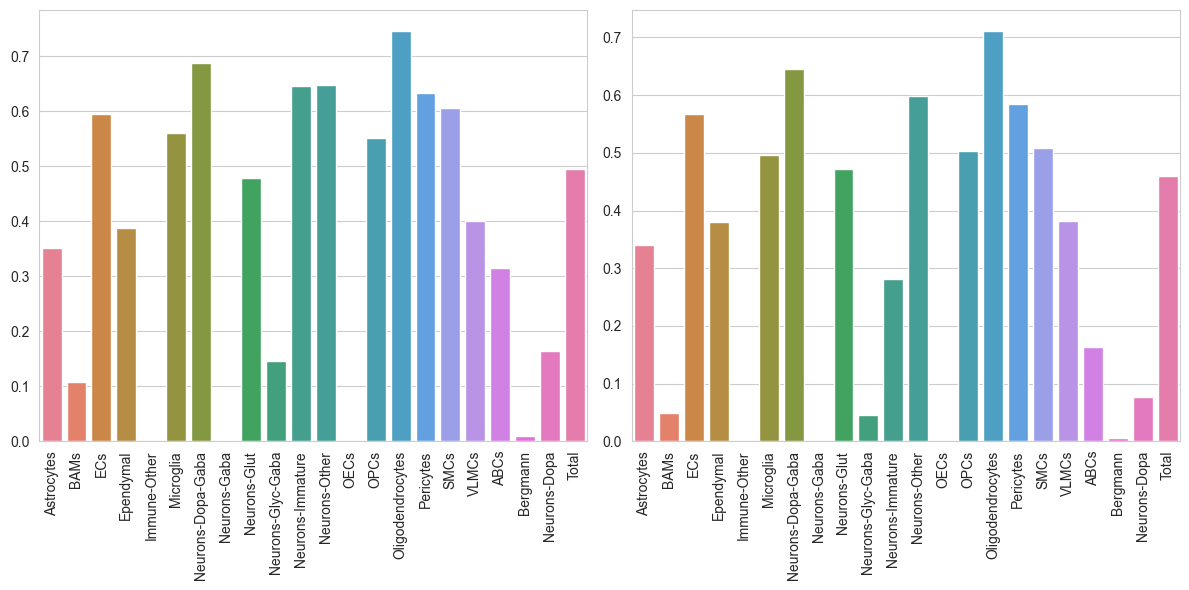

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.barplot(
    data=compute_f1(area, general_stats, correct_celltypes=correct_celltypes),
    ax=axes[0],
)
axes[0].tick_params(axis="x", rotation=90)

sns.barplot(
    data=compute_f1(area_weight, general_stats, correct_celltypes=correct_celltypes),
    ax=axes[1],
)
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

In [11]:
data = compute_f1(area, general_stats).astype(float)
data.columns

Index(['ABCs', 'Astrocytes', 'BAMs', 'Bergmann', 'ECs', 'Ependymal',
       'Immune-Other', 'Microglia', 'Neurons-Dopa', 'Neurons-Dopa-Gaba',
       'Neurons-Gaba', 'Neurons-Glut', 'Neurons-Glyc-Gaba', 'Neurons-Immature',
       'Neurons-Other', 'OECs', 'OPCs', 'Oligodendrocytes', 'Pericytes',
       'SMCs', 'VLMCs'],
      dtype='object')

In [14]:
data.index = pd.CategoricalIndex(data.index, categories=index_order)
data.sort_index(level=0, inplace=True)
data = data[column_order]
data

,Astrocytes,BAMs,ECs,Ependymal,Immune-Other,Microglia,Neurons-Dopa,Neurons-Gaba,Neurons-Glut,Neurons-Glyc-Gaba,...,OPCs,Oligodendrocytes,Pericytes,SMCs,VLMCs,ABCs,Bergmann,Neurons-Dopa-Gaba,Neurons-Immature,OECs
Astrocytes,0.258069,0.010390,0.037225,0.006133,0.005907,0.012154,0.008499,0.040547,0.020527,0.002577,...,0.010128,0.004473,0.009782,0.005475,0.003226,0.022250,0.009853,0.006021,0.009266,0.004818
BAMs,0.002303,0.107857,0.008639,0.007954,0.461965,0.020810,0.000281,0.000007,0.000081,0.000914,...,0.000594,0.001632,0.009748,0.015452,0.106587,0.011587,0.000121,0.000358,0.000168,0.001073
ECs,0.040197,0.050560,0.595445,0.020779,0.049491,0.038129,0.027310,0.028821,0.027668,0.020968,...,0.022584,0.010455,0.065195,0.018826,0.124649,0.033581,0.041907,0.024527,0.009987,0.026625
Ependymal,0.002775,0.000924,0.001539,0.217592,0.003215,0.006224,0.003041,0.000939,0.000590,0.001080,...,0.003740,0.002176,0.000154,0.000658,0.001180,0.000000,0.000350,0.000437,0.000255,0.000000
Immune-Other,0.000073,0.000636,0.000046,0.000119,0.000772,0.000224,0.000425,0.001866,0.001729,0.001476,...,0.000073,0.000013,0.000593,0.000098,0.000061,0.000000,0.000134,0.001747,0.000060,0.000766
Microglia,0.025909,0.029599,0.032498,0.012192,0.016478,0.560465,0.018889,0.020900,0.025324,0.022899,...,0.012210,0.054176,0.051200,0.004192,0.007716,0.017953,0.014734,0.018817,0.005583,0.009992
Neurons-Dopa,0.071906,0.052991,0.022033,0.050260,0.055719,0.043874,0.164148,0.768785,0.018943,0.759386,...,0.055975,0.082563,0.027892,0.018059,0.013406,0.023716,0.032020,0.687374,0.025264,0.090467
Neurons-Gaba,0.002613,0.001984,0.001912,0.001530,0.000129,0.002936,0.057201,0.001705,0.005632,0.001100,...,0.003384,0.002733,0.001173,0.000163,0.000156,0.000000,0.003499,0.024201,0.002047,0.000843
Neurons-Glut,0.047766,0.069118,0.027014,0.045928,0.072732,0.042545,0.171341,0.011250,0.478381,0.014985,...,0.049180,0.013705,0.022397,0.012260,0.100873,0.063568,0.064204,0.027410,0.028067,0.063681
Neurons-Glyc-Gaba,0.006307,0.005804,0.003103,0.004584,0.028566,0.003888,0.004966,0.007787,0.010445,0.146370,...,0.005023,0.005623,0.002262,0.004536,0.001135,0.001844,0.008485,0.199379,0.002967,0.004207


<Axes: >

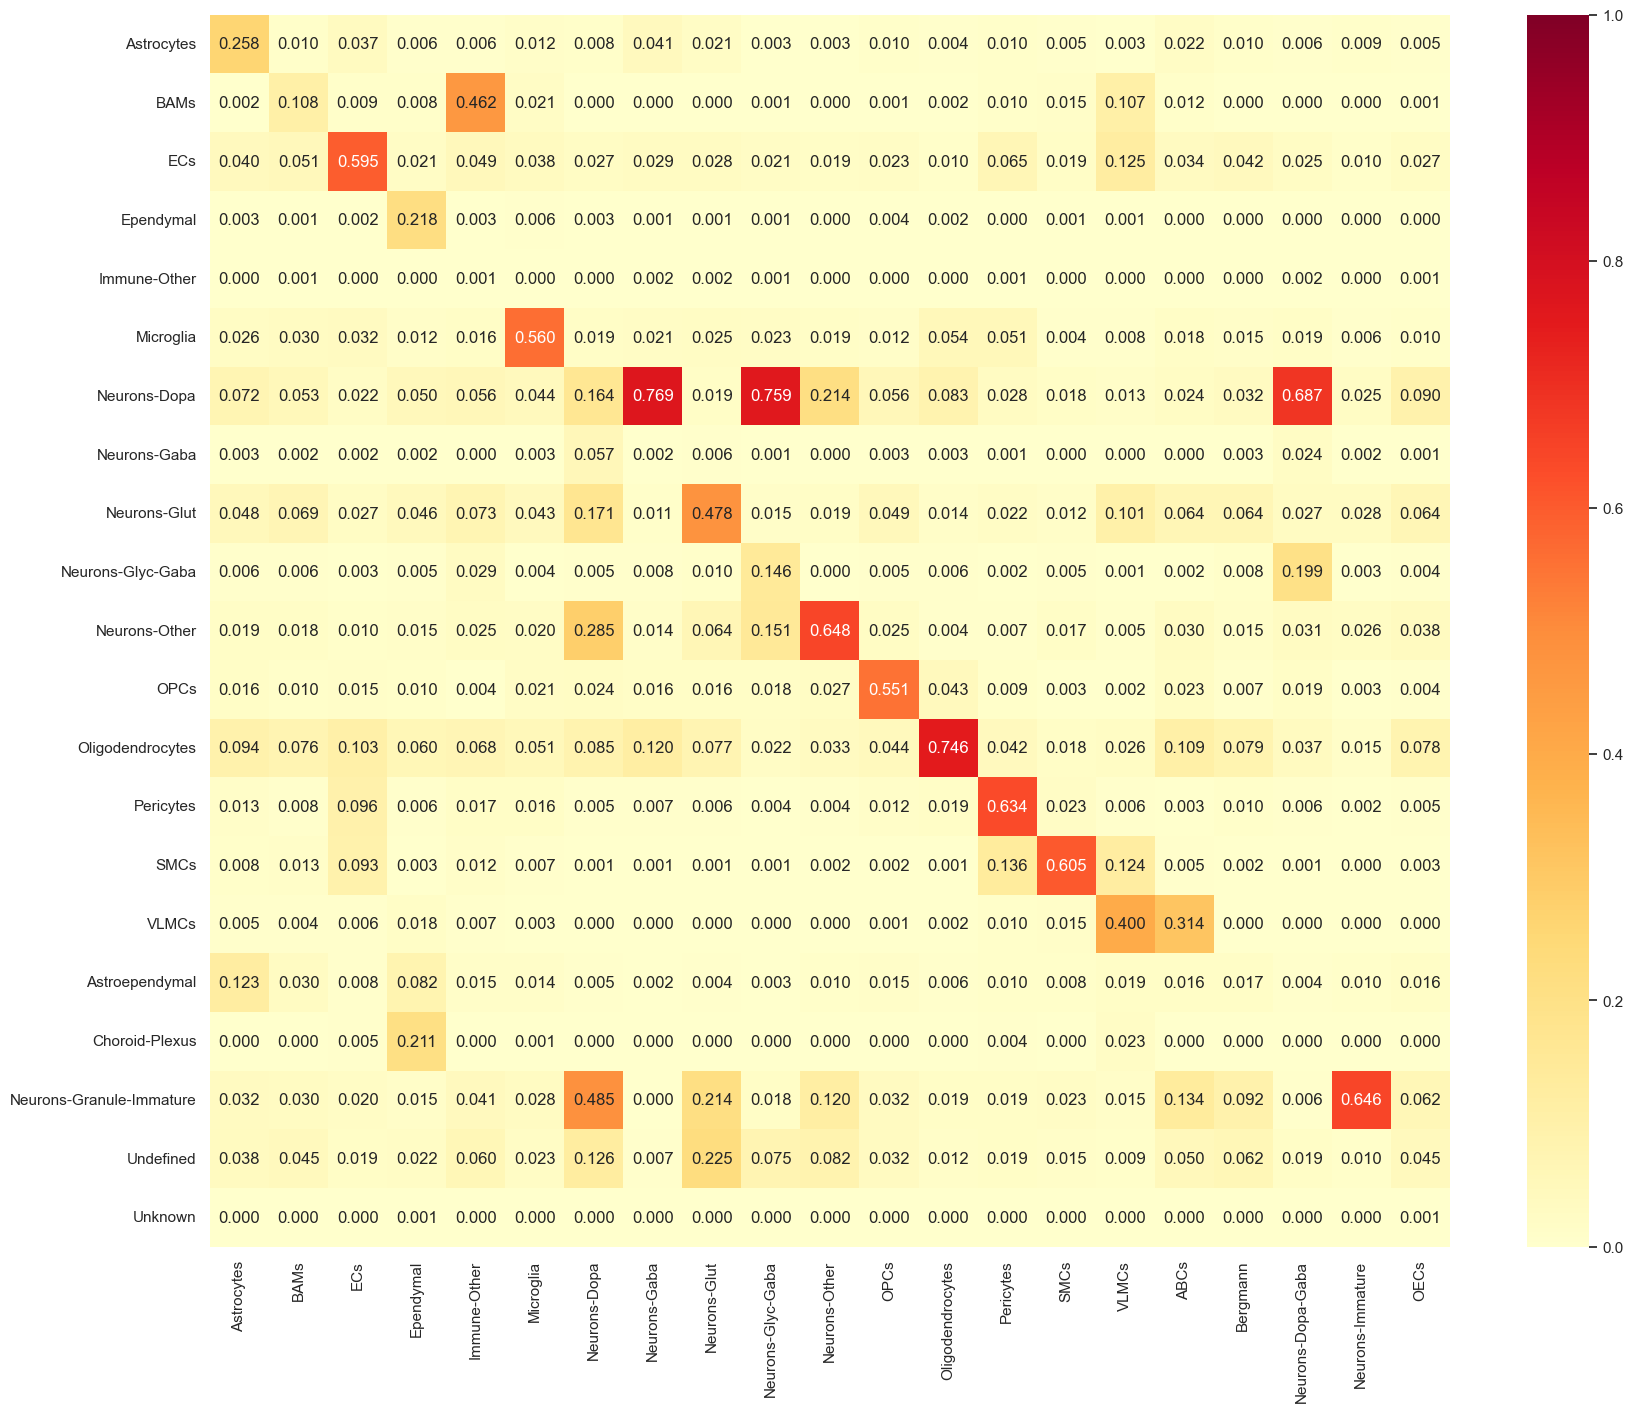

In [15]:
sns.set_theme(rc={"figure.figsize": (20, 16)})
sns.heatmap(data, fmt=".3f", cmap="YlOrRd", vmin=0, vmax=1, annot=True)

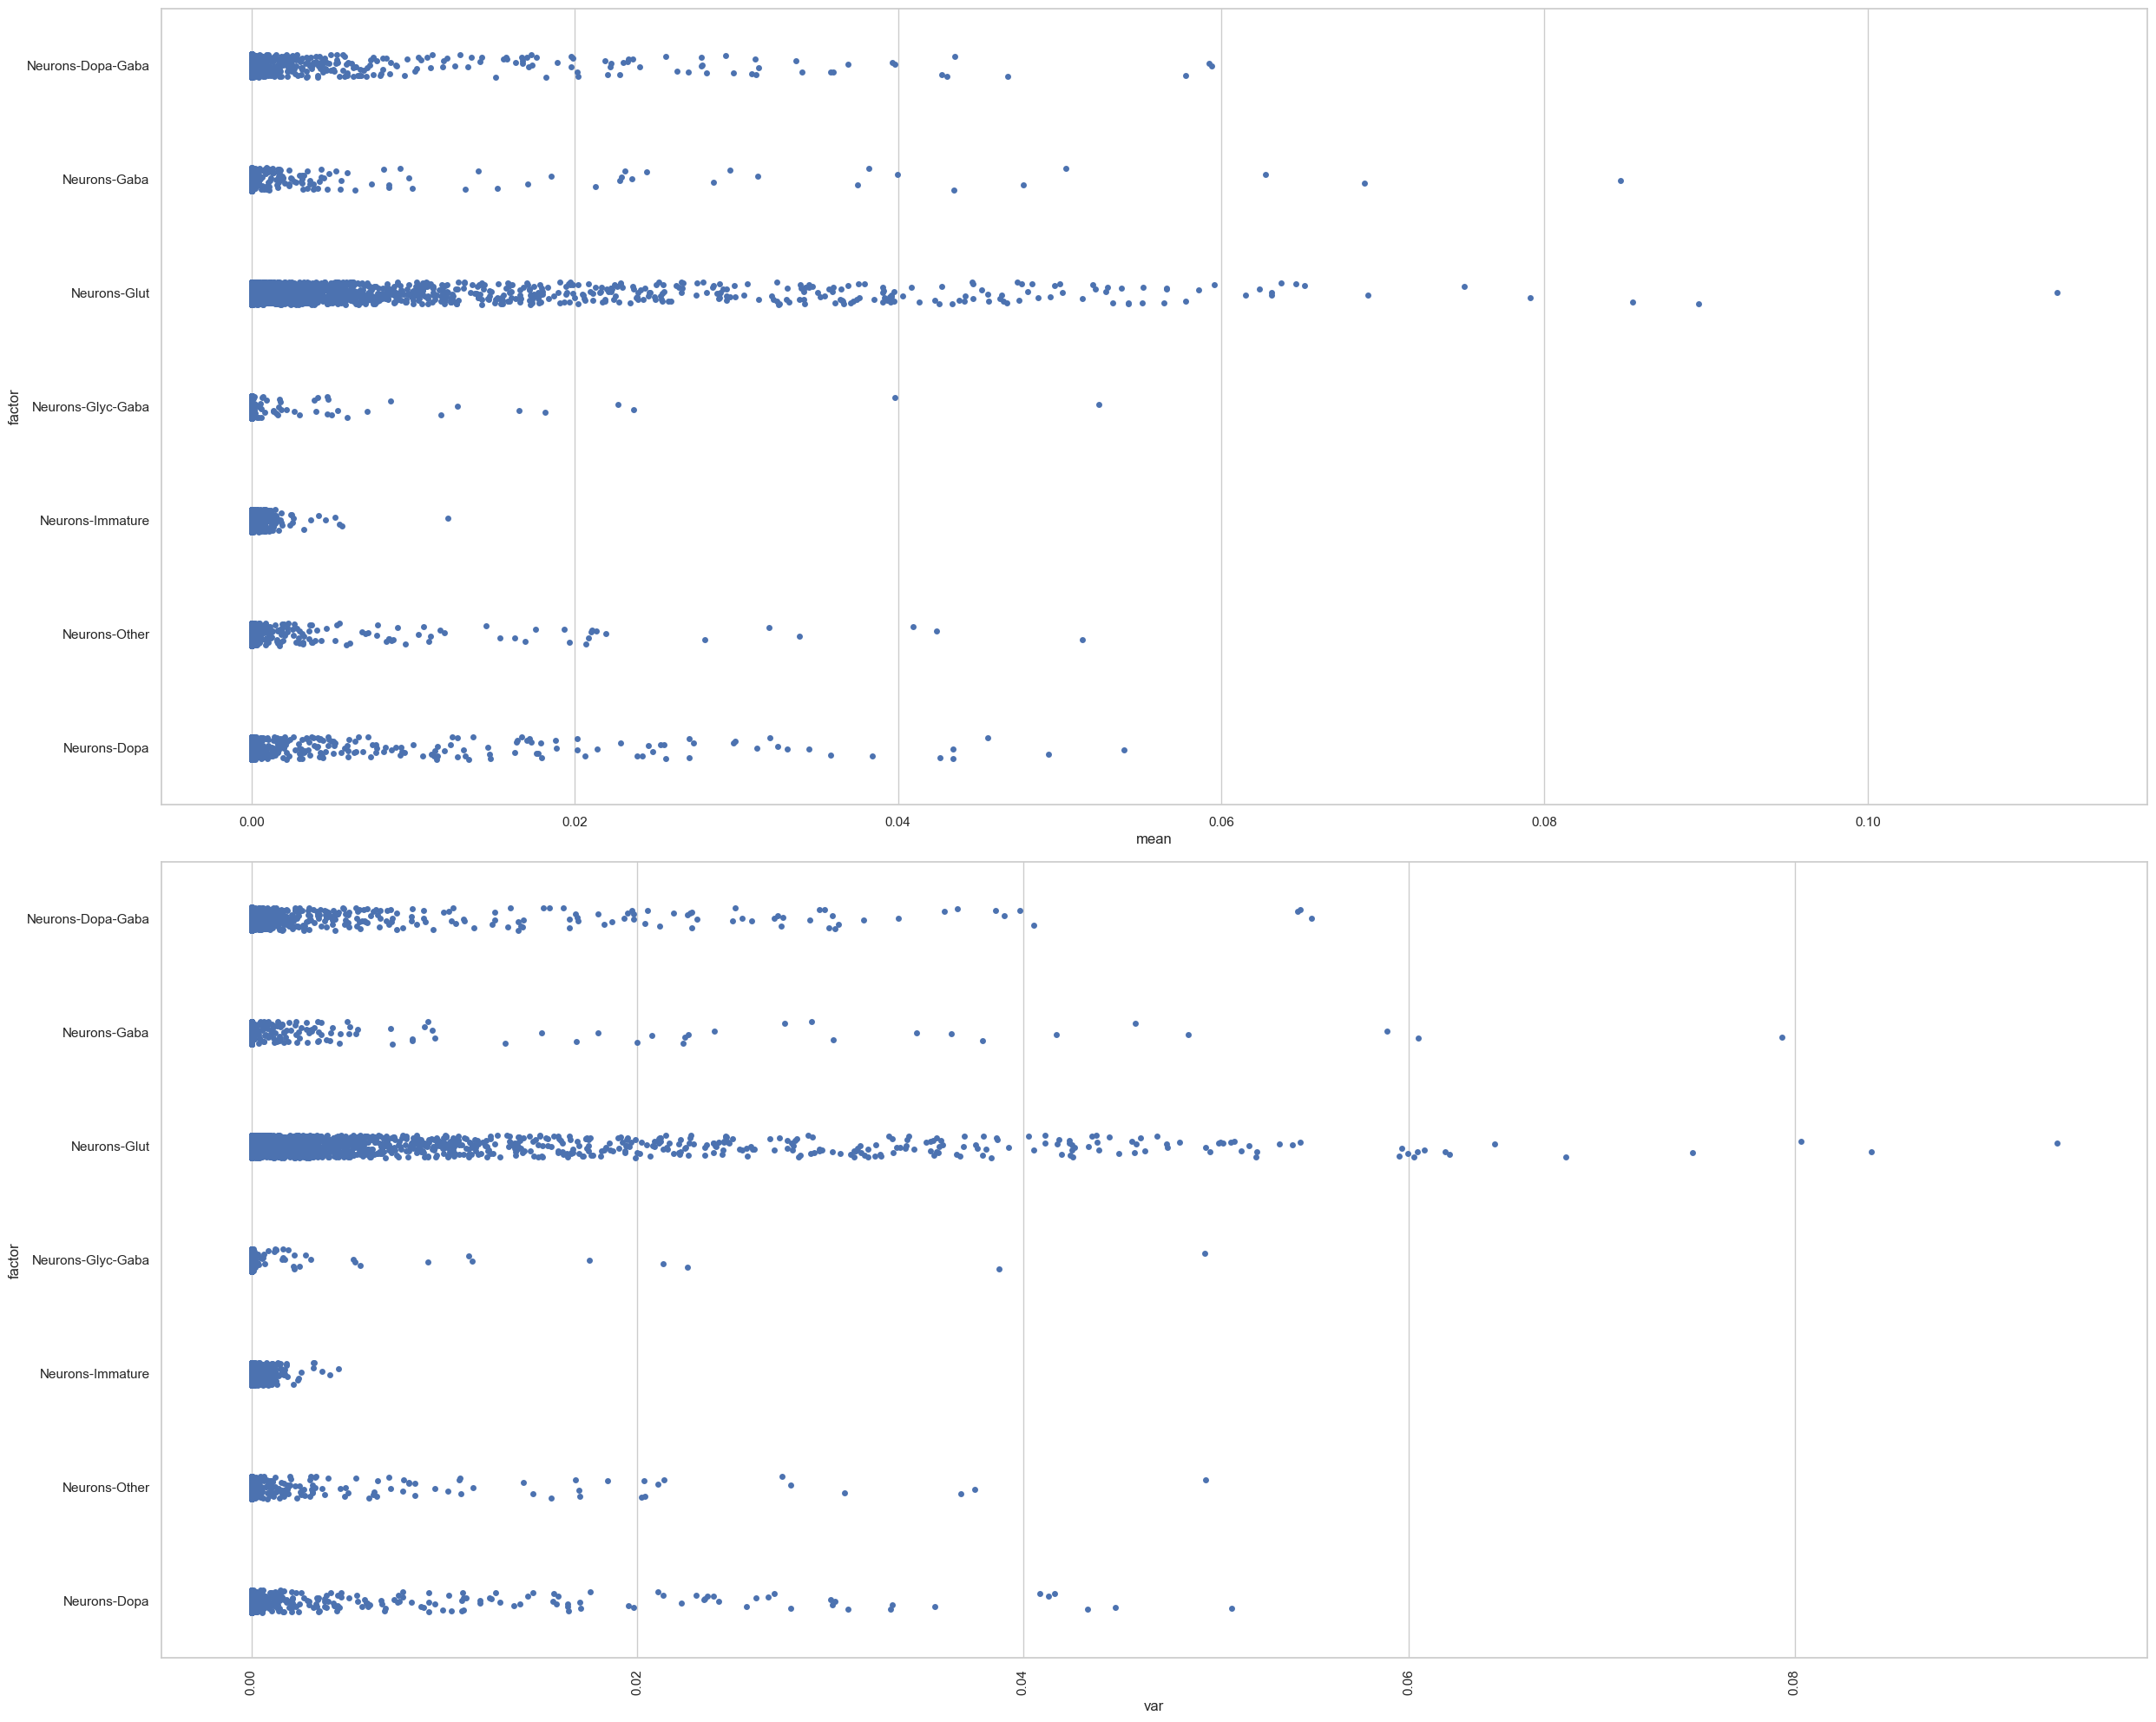

In [29]:
fig, axes = plt.subplots(2, 1, figsize=(25, 20))
# sns.set_theme(rc={'figure.figsize':(25,10)})
sns.stripplot(
    pd.melt(
        means_weight[
            (
                annotation.merge(
                    means_weight, left_index=True, right_index=True, how="right"
                )["cell type"]
                == "ECs"
            ).values
        ][[x for x in means_weight.columns if x.startswith("Neurons")]],
        var_name="factor",
        value_name="mean",
    ),
    y="factor",
    x="mean",
    ax=axes[0],
)
# sns.set_theme(rc={'figure.figsize': (25, 10)})
sns.stripplot(
    pd.melt(
        vars_weight[
            (
                annotation.merge(
                    vars_weight, left_index=True, right_index=True, how="right"
                )["cell type"]
                == "ECs"
            ).values
        ][[x for x in vars_weight.columns if x.startswith("Neurons")]],
        var_name="factor",
        value_name="var",
    ),
    y="factor",
    x="var",
    ax=axes[1],
)
plt.tight_layout()

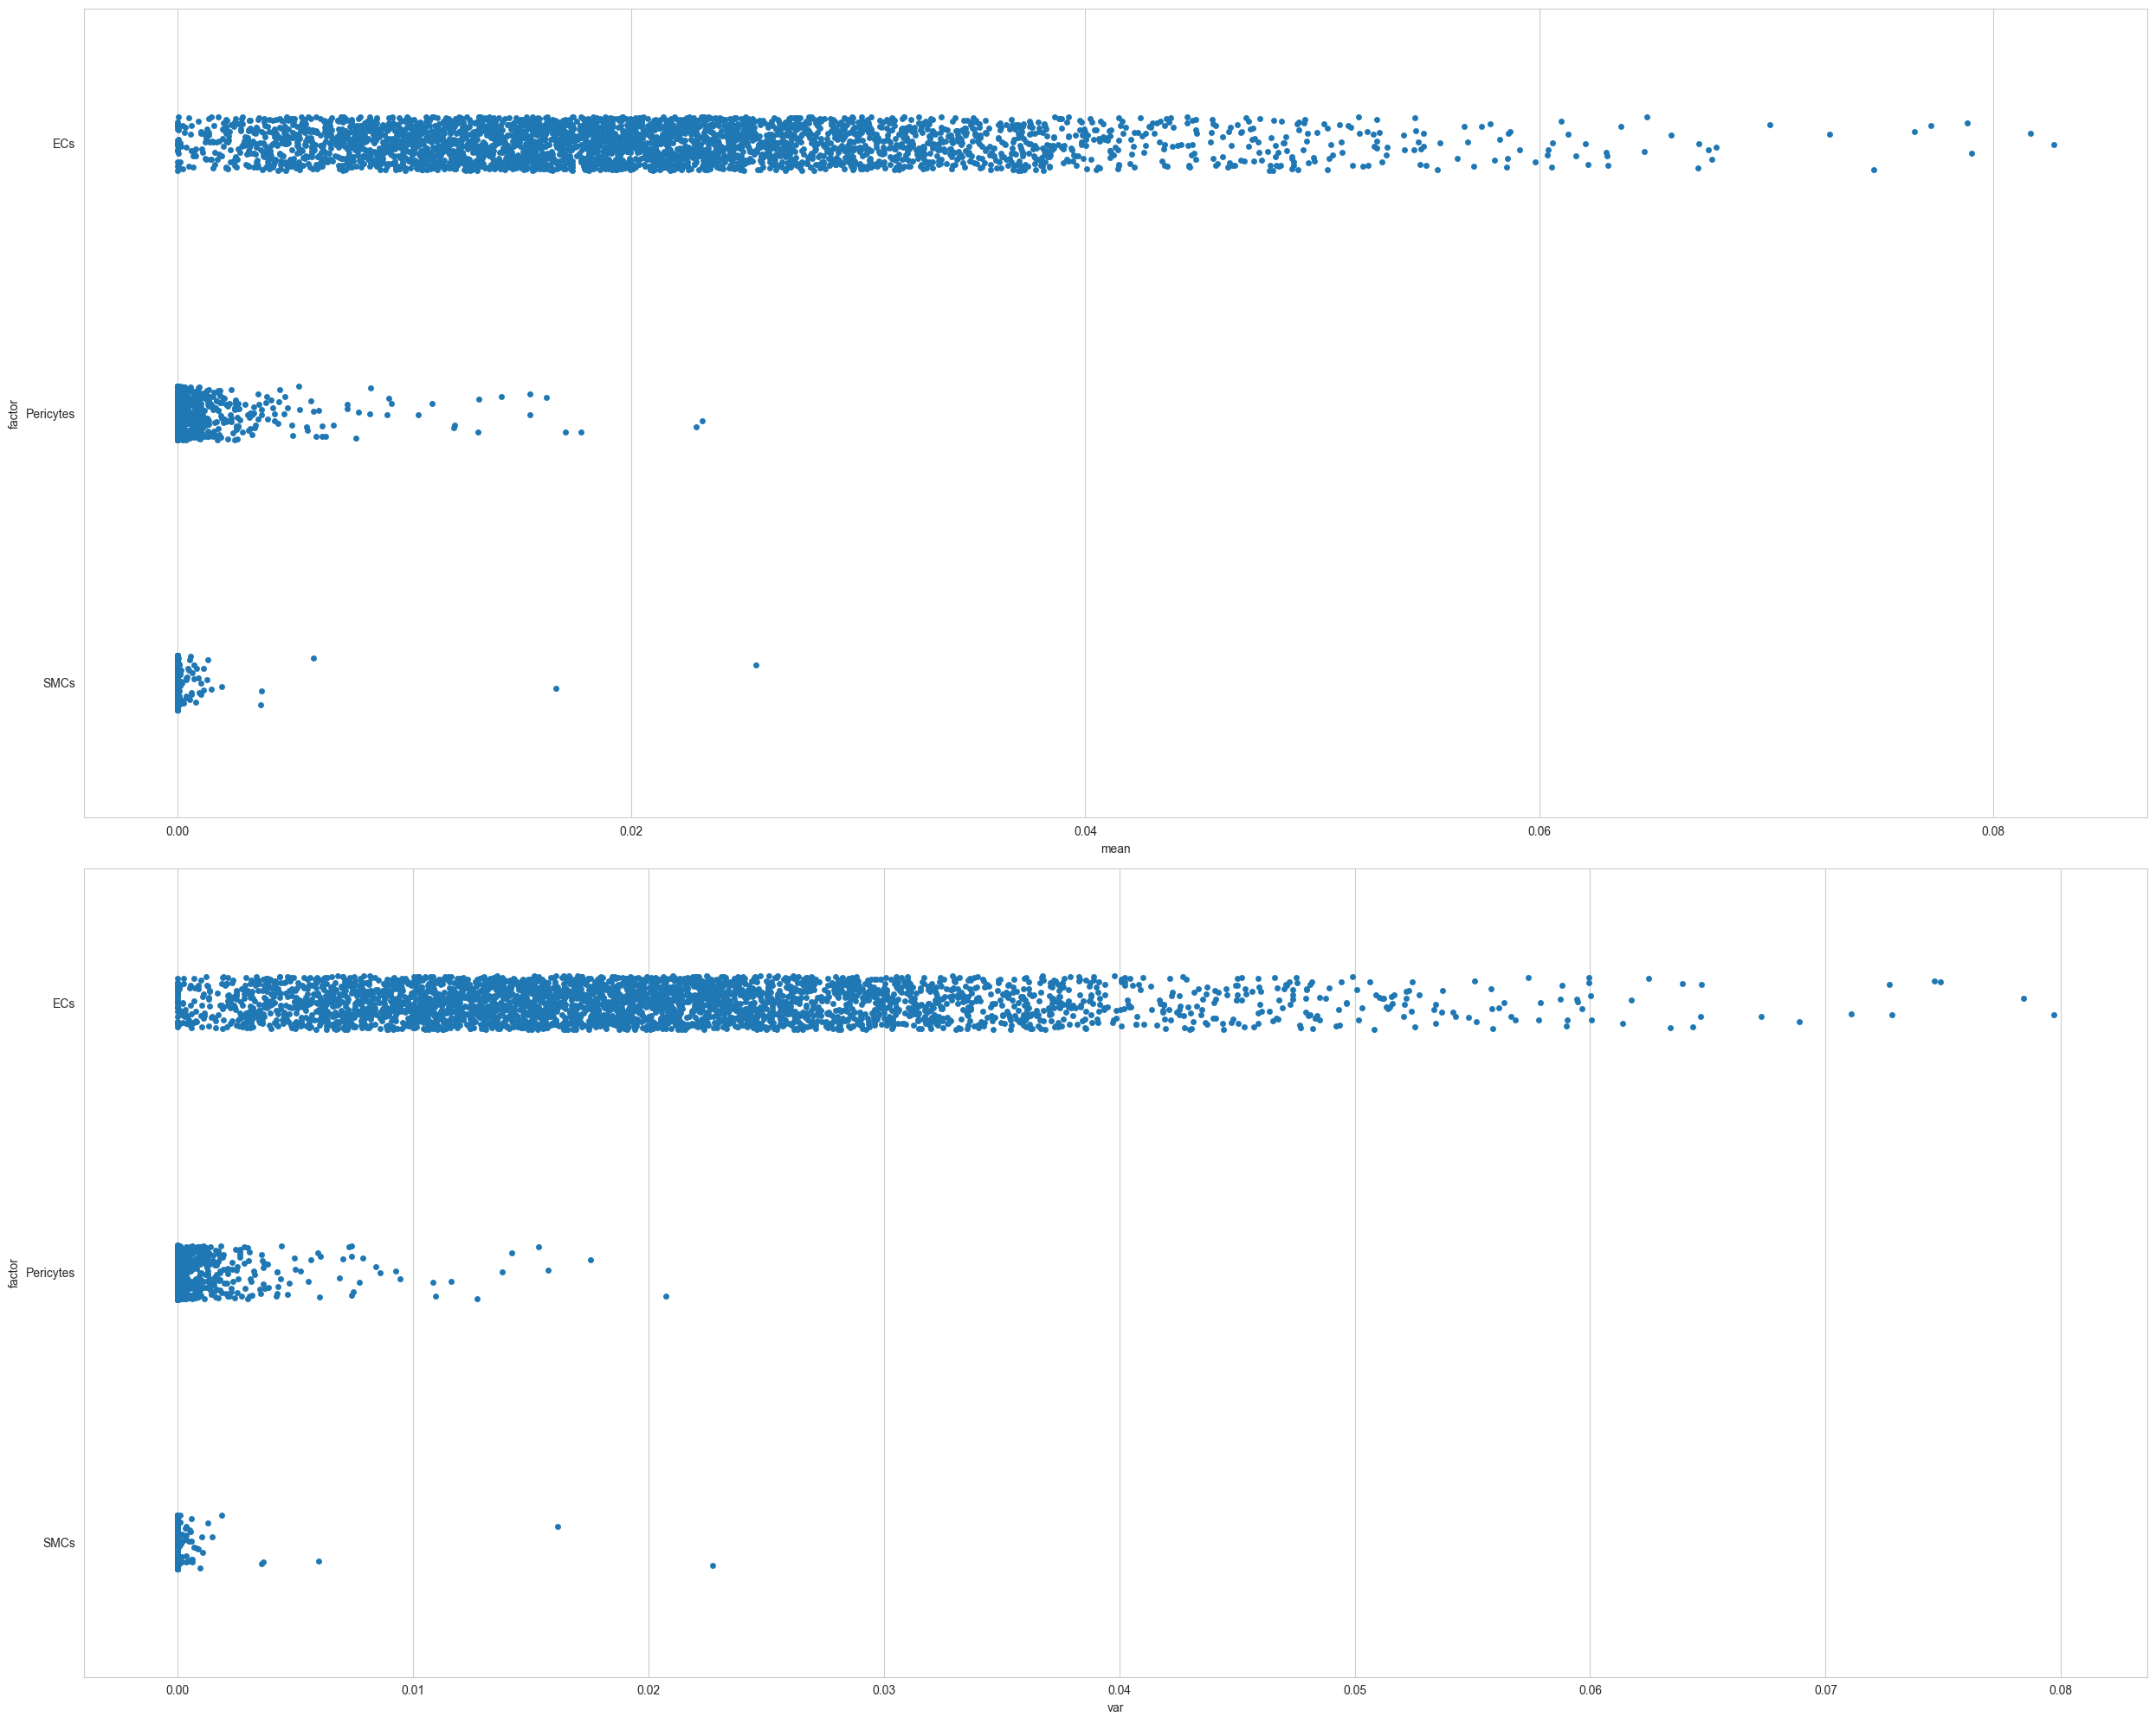

In [11]:
fig, axes = plt.subplots(2, 1, figsize=(25, 20))
# sns.set_theme(rc={'figure.figsize':(25,10)})
sns.stripplot(
    pd.melt(
        means_weight[
            (
                annotation.merge(
                    means_weight, left_index=True, right_index=True, how="right"
                )["cell type"]
                == "ECs"
            ).values
        ][["ECs", "Pericytes", "SMCs"]],
        var_name="factor",
        value_name="mean",
    ),
    y="factor",
    x="mean",
    ax=axes[0],
)
# sns.set_theme(rc={'figure.figsize': (25, 10)})
sns.stripplot(
    pd.melt(
        vars_weight[
            (
                annotation.merge(
                    vars_weight, left_index=True, right_index=True, how="right"
                )["cell type"]
                == "ECs"
            ).values
        ][["ECs", "Pericytes", "SMCs"]],
        var_name="factor",
        value_name="var",
    ),
    y="factor",
    x="var",
    ax=axes[1],
)
plt.tight_layout()

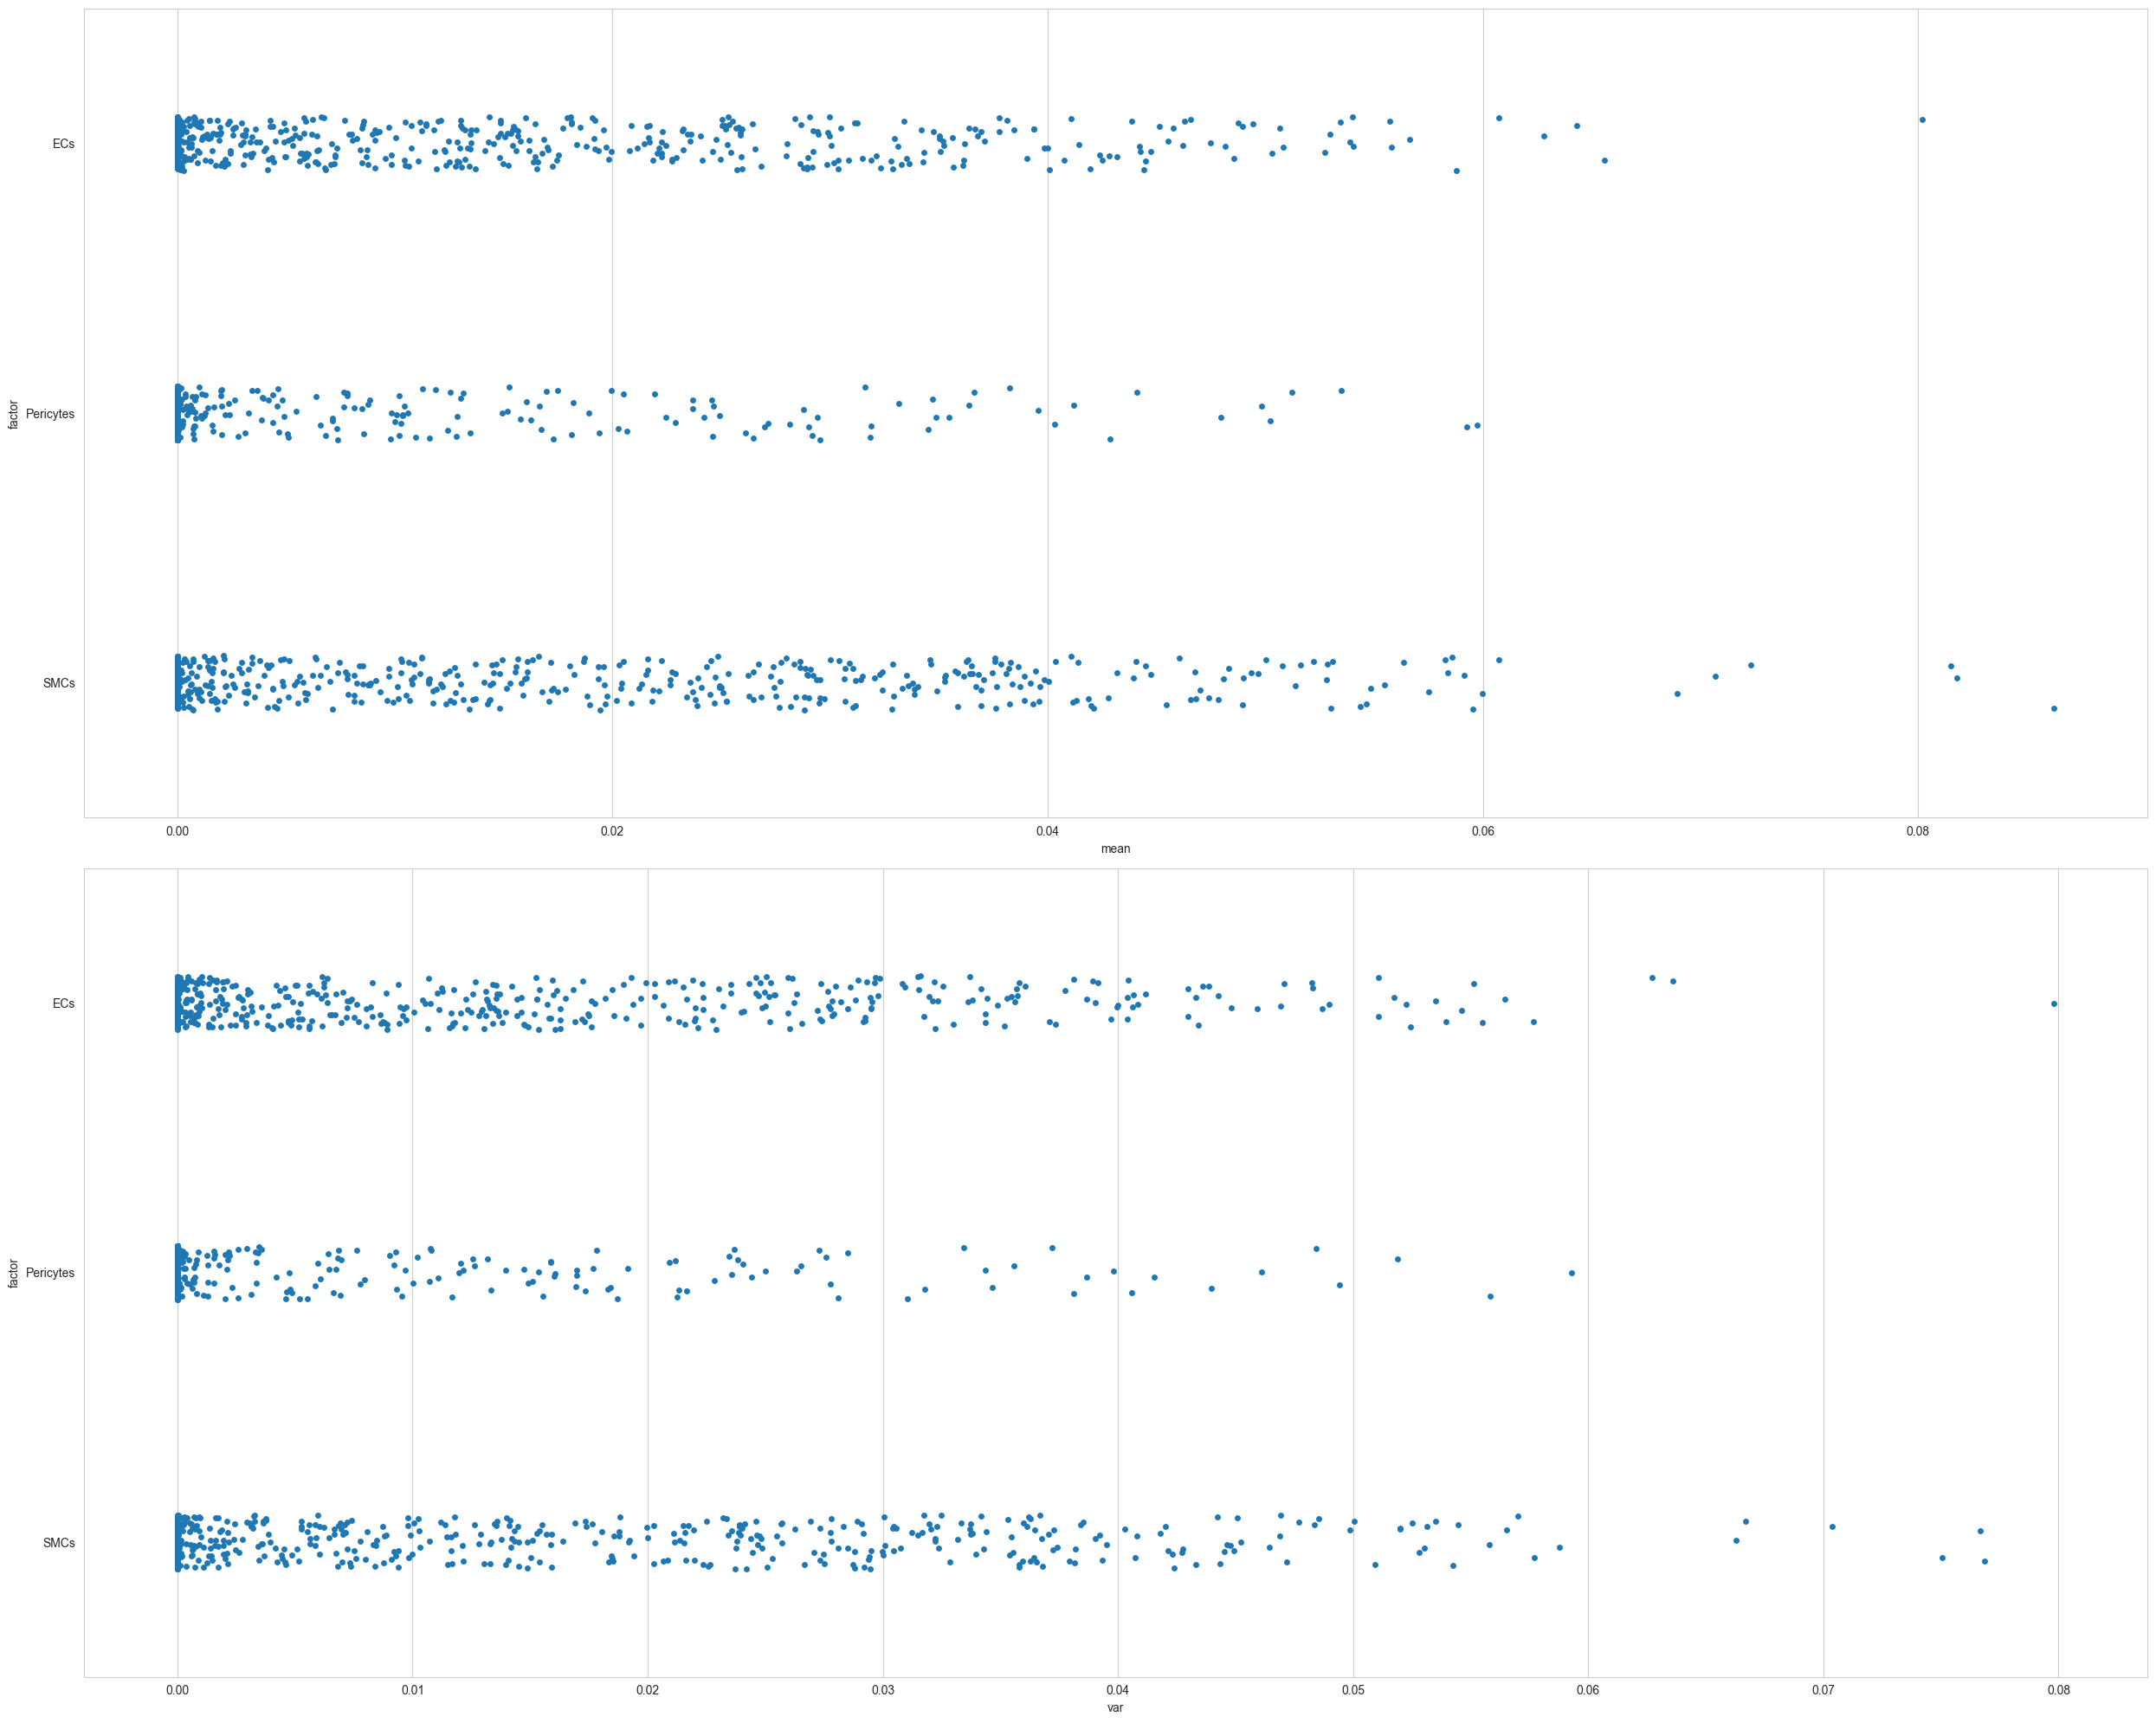

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(25, 20))
# sns.set_theme(rc={'figure.figsize':(25,10)})
sns.stripplot(
    pd.melt(
        means_weight[
            (
                annotation.merge(
                    means_weight, left_index=True, right_index=True, how="right"
                )["cell type"]
                == "SMCs"
            ).values
        ][["ECs", "Pericytes", "SMCs"]],
        var_name="factor",
        value_name="mean",
    ),
    y="factor",
    x="mean",
    ax=axes[0],
)
# sns.set_theme(rc={'figure.figsize': (25, 10)})
sns.stripplot(
    pd.melt(
        vars_weight[
            (
                annotation.merge(
                    vars_weight, left_index=True, right_index=True, how="right"
                )["cell type"]
                == "SMCs"
            ).values
        ][["ECs", "Pericytes", "SMCs"]],
        var_name="factor",
        value_name="var",
    ),
    y="factor",
    x="var",
    ax=axes[1],
)
plt.tight_layout()

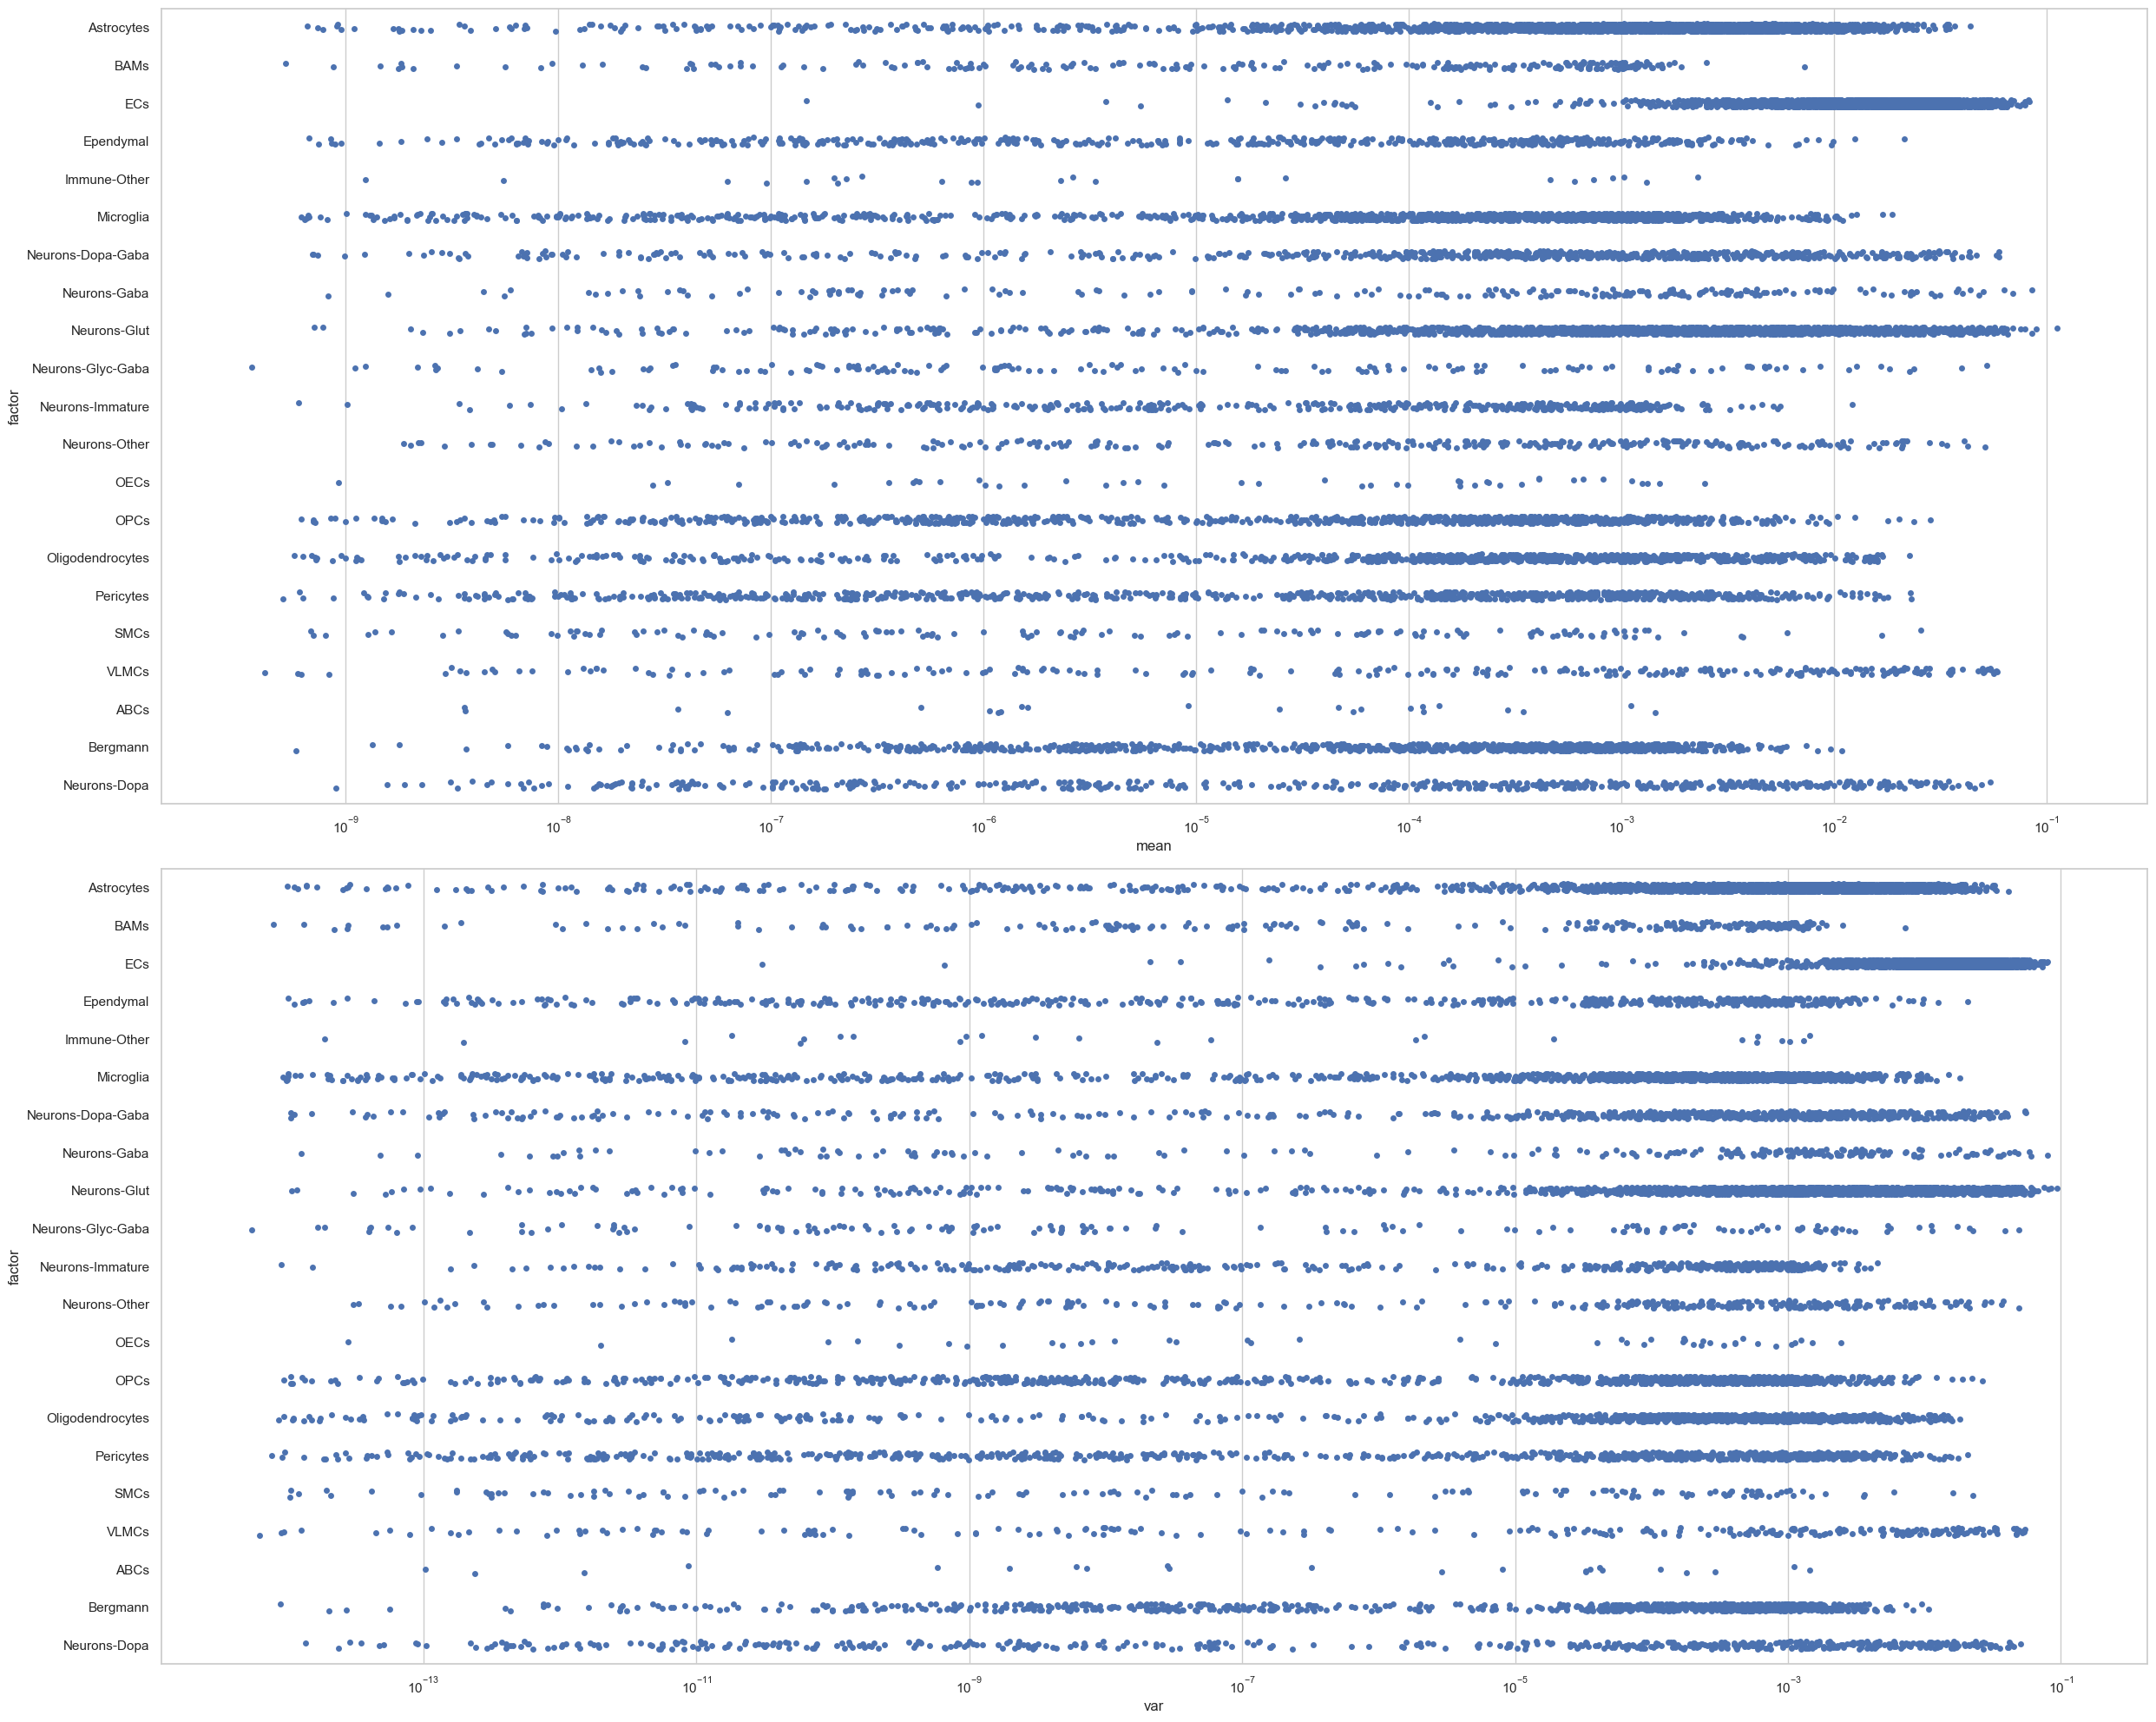

In [31]:
fig, axes = plt.subplots(2, 1, figsize=(25, 20))
sns.stripplot(
    pd.melt(
        means_weight[
            (
                annotation.merge(
                    means_weight, left_index=True, right_index=True, how="right"
                )["cell type"]
                == "ECs"
            ).values
        ],
        var_name="factor",
        value_name="mean",
    ),
    y="factor",
    x="mean",
    ax=axes[0],
    log_scale=True,
)
sns.stripplot(
    pd.melt(
        vars_weight[
            (
                annotation.merge(
                    vars_weight, left_index=True, right_index=True, how="right"
                )["cell type"]
                == "ECs"
            ).values
        ],
        var_name="factor",
        value_name="var",
    ),
    y="factor",
    x="var",
    ax=axes[1],
    log_scale=True,
)
plt.tight_layout()

In [39]:
mean_melt = pd.melt(
    means[
        (
            annotation.merge(means, left_index=True, right_index=True, how="right")[
                "cell type"
            ]
            == "ECs"
        ).values
    ],
    var_name="factor",
    value_name="mean",
    ignore_index=False,
)
mean_melt["cell_id"] = mean_melt.index
var_melt = pd.melt(
    vars[
        (
            annotation.merge(vars, left_index=True, right_index=True, how="right")[
                "cell type"
            ]
            == "ECs"
        ).values
    ],
    var_name="factor",
    value_name="vars",
    ignore_index=False,
)
var_melt["cell_id"] = var_melt.index
mean_melt.merge(
    var_melt, left_on=["cell_id", "factor"], right_on=["cell_id", "factor"], how="left"
)

,factor,mean,cell_id,vars
0,Astrocytes,0.000000,aaaaaaaa-1,0.000000
1,Astrocytes,0.006968,aaaaaaac-1,0.006965
2,Astrocytes,0.000000,aaaaaaga-1,0.000000
3,Astrocytes,0.009118,aaaaaagc-1,0.009075
4,Astrocytes,0.008172,aaaaaagj-1,0.008164
...,...,...,...,...
78472,Neurons-Dopa,0.000000,aaaammmb-1,0.000000
78473,Neurons-Dopa,0.000053,aaaammng-1,0.000053
78474,Neurons-Dopa,0.000000,aaaammnk-1,0.000000
78475,Neurons-Dopa,0.000000,aaaammok-1,0.000000


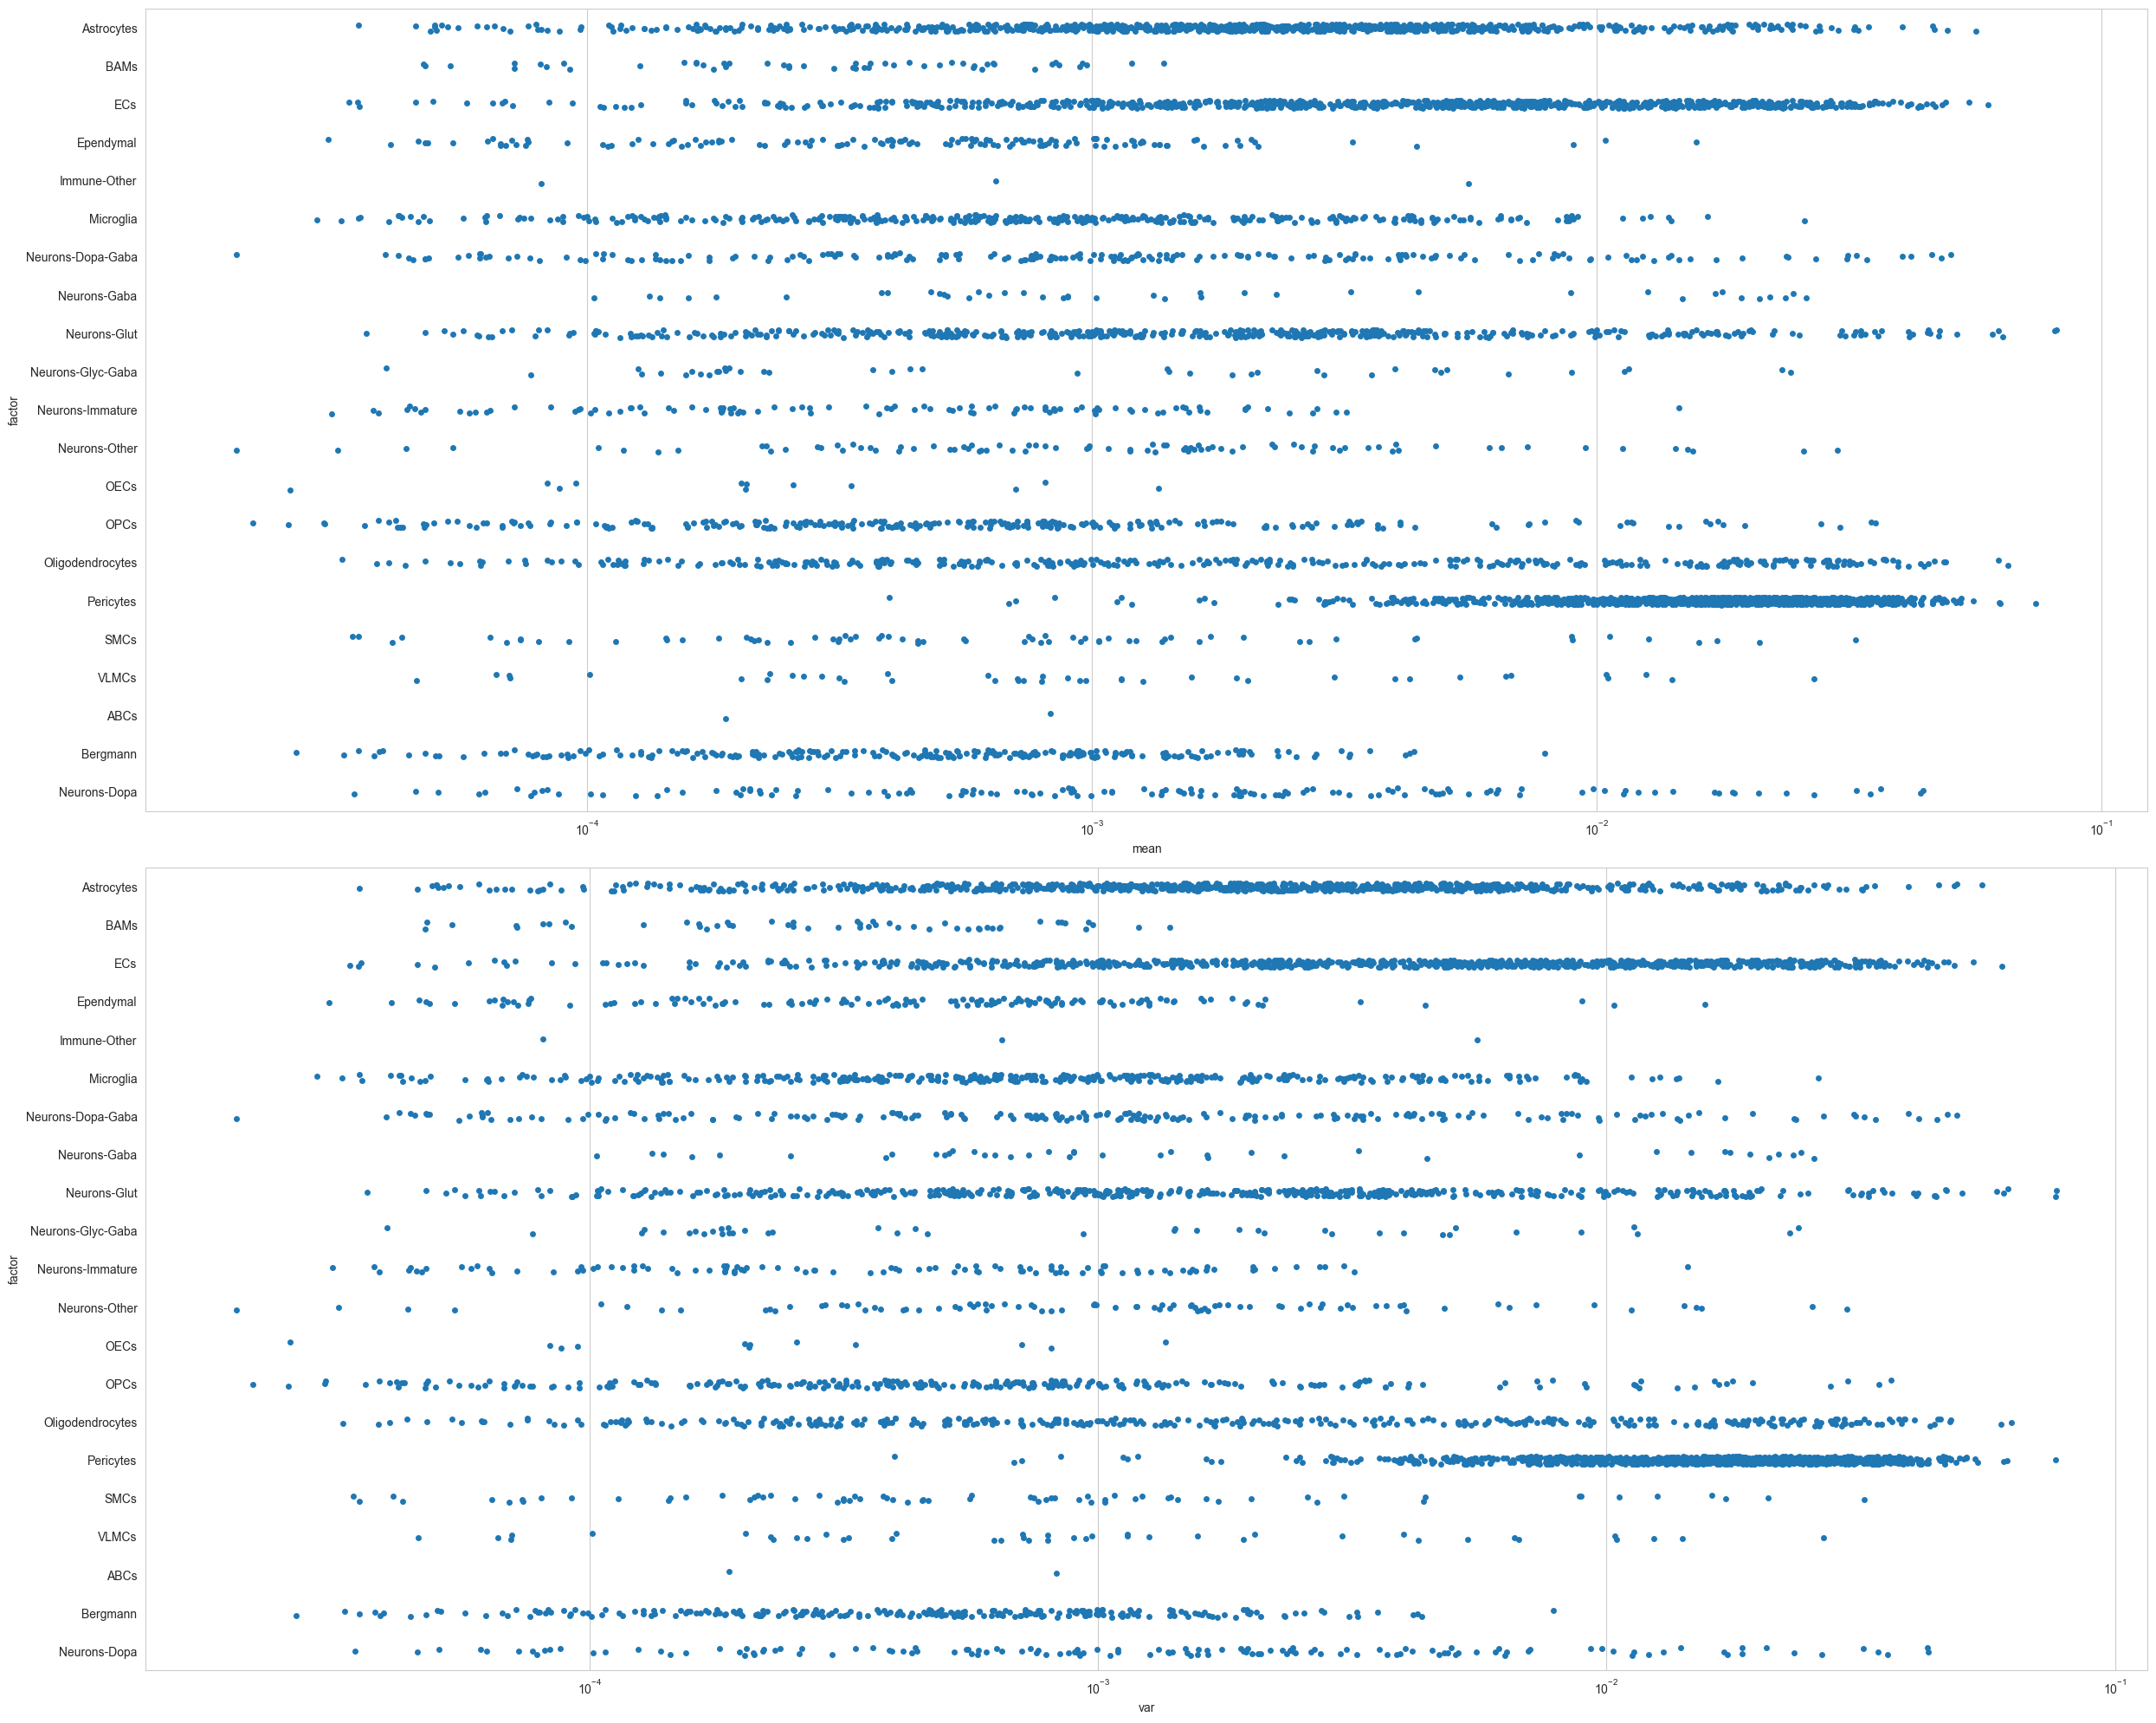

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(25, 20))
sns.stripplot(
    pd.melt(
        means[
            (
                annotation.merge(means, left_index=True, right_index=True, how="right")[
                    "cell type"
                ]
                == "Pericytes"
            ).values
        ],
        var_name="factor",
        value_name="mean",
    ),
    y="factor",
    x="mean",
    ax=axes[0],
    log_scale=True,
)
sns.stripplot(
    pd.melt(
        vars[
            (
                annotation.merge(vars, left_index=True, right_index=True, how="right")[
                    "cell type"
                ]
                == "Pericytes"
            ).values
        ],
        var_name="factor",
        value_name="var",
    ),
    y="factor",
    x="var",
    ax=axes[1],
    log_scale=True,
)
plt.tight_layout()

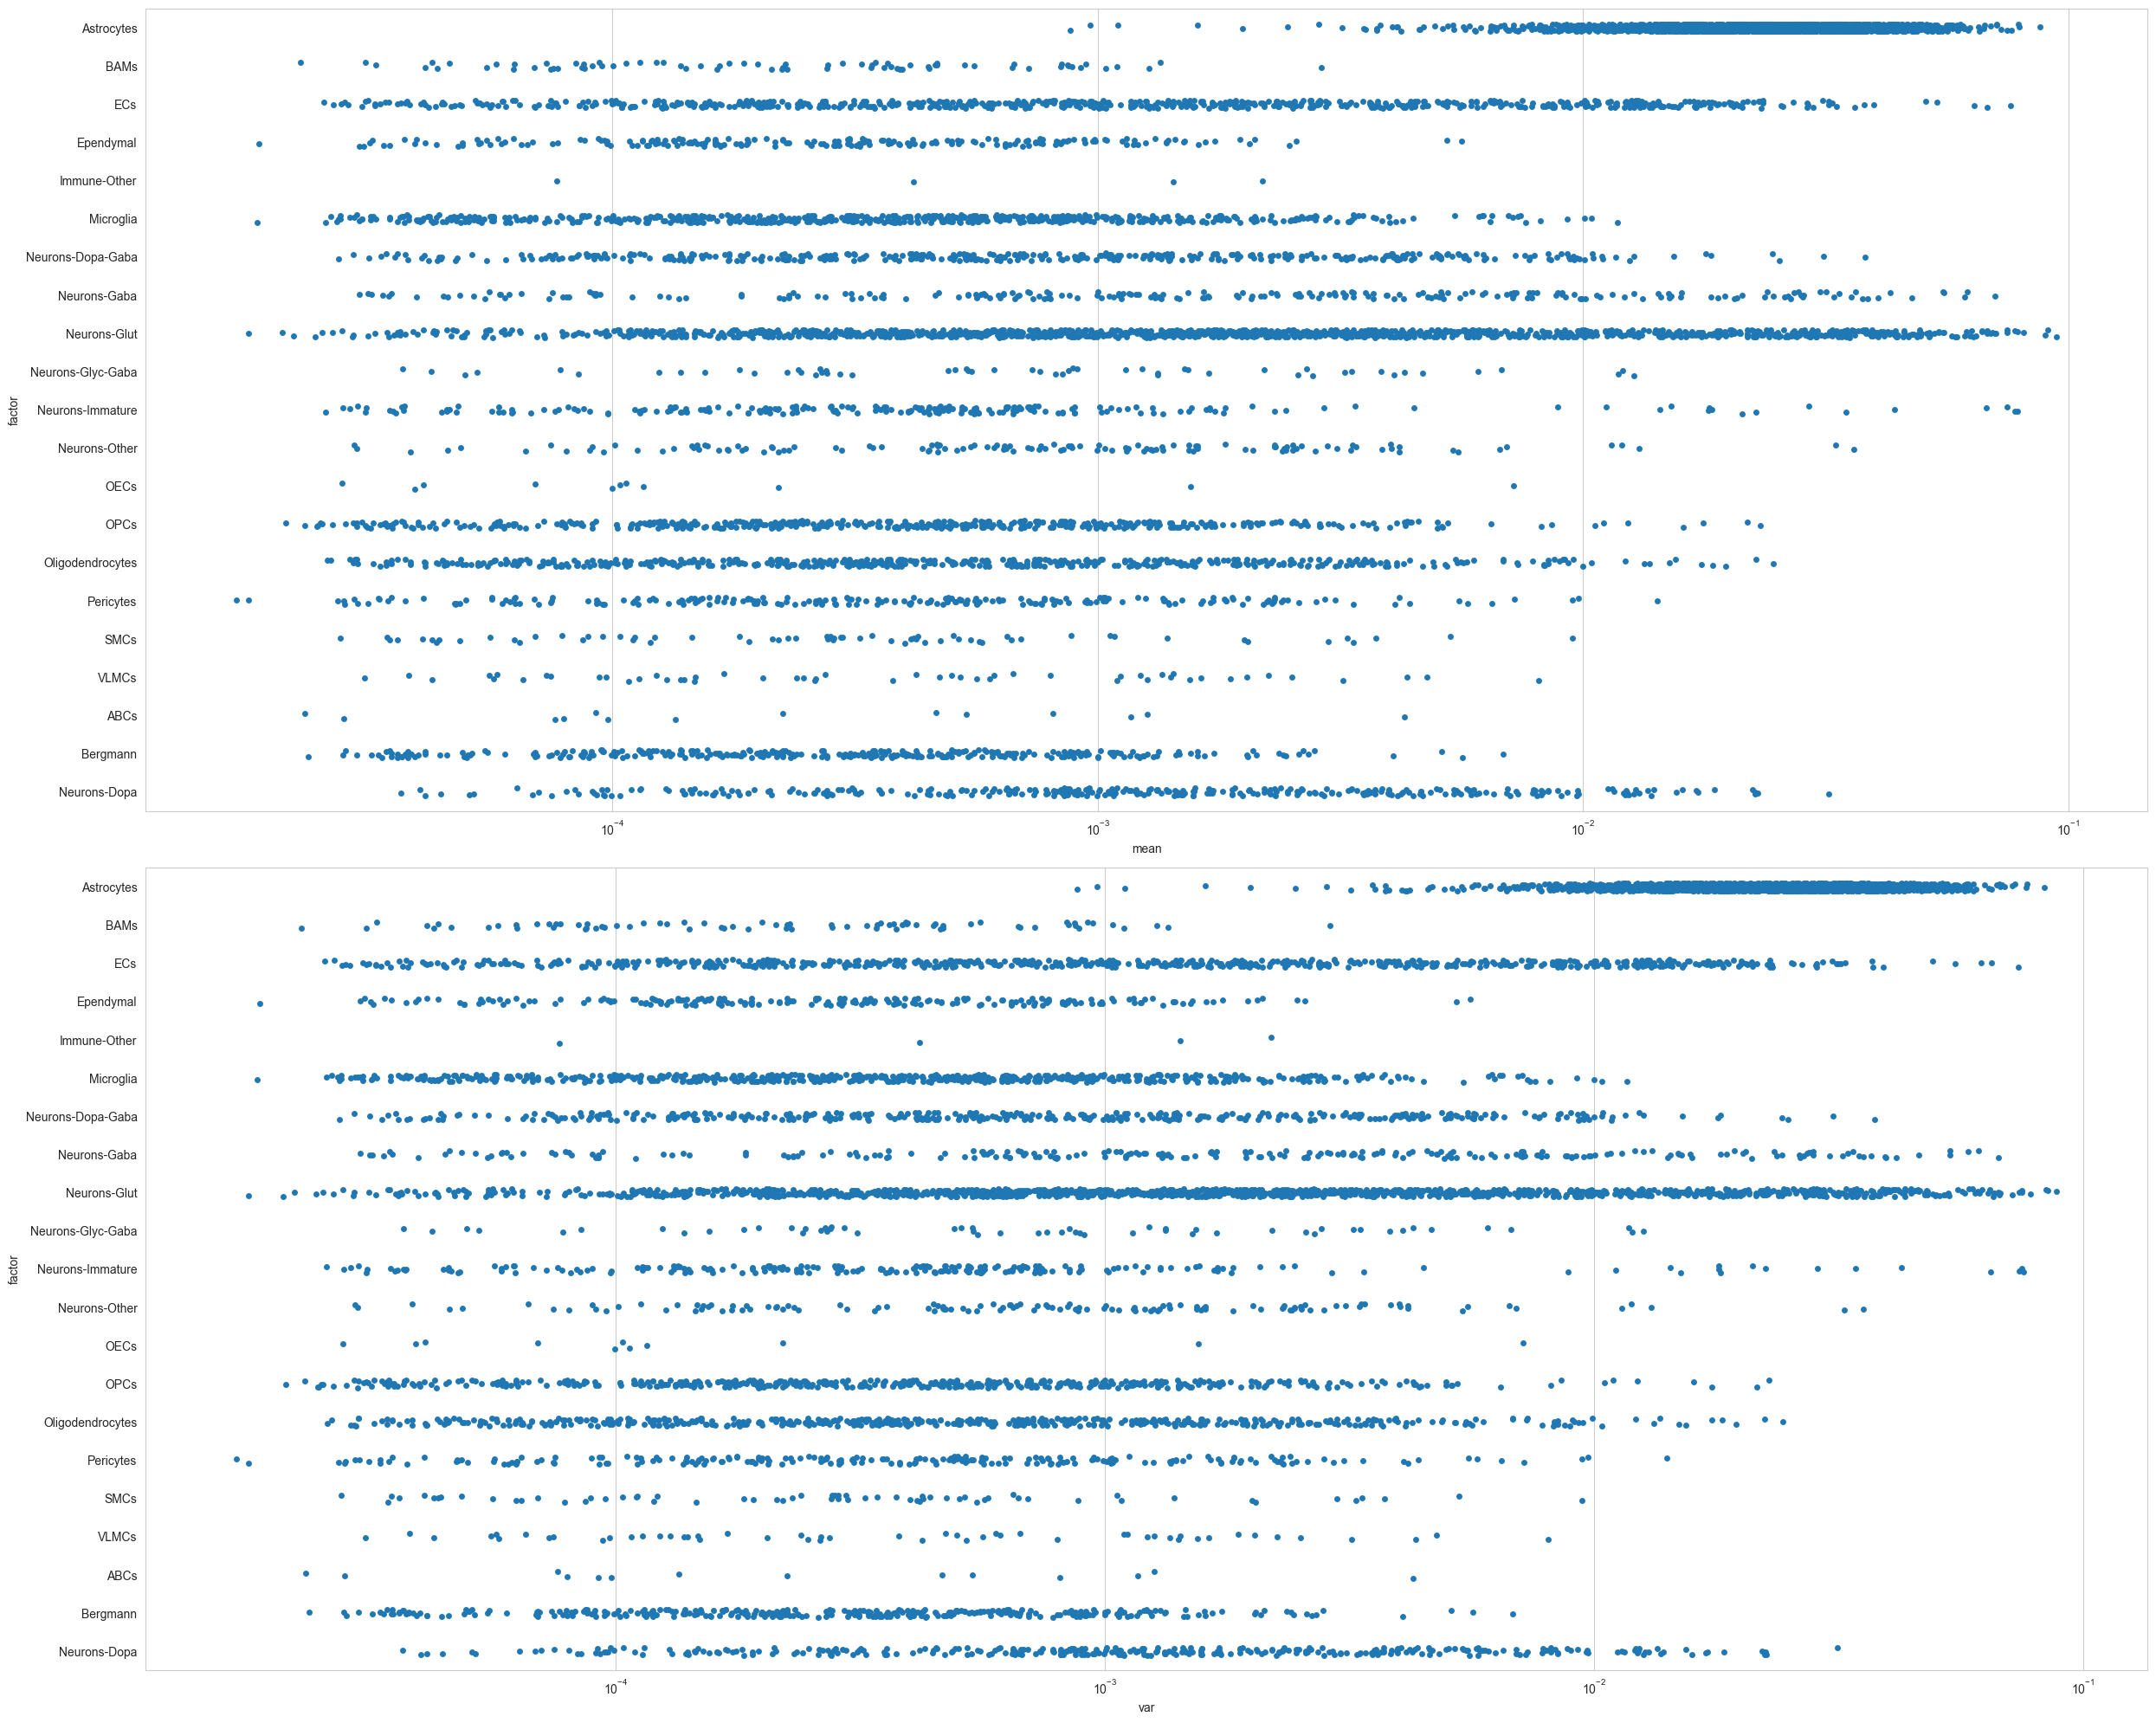

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(25, 20))
sns.stripplot(
    pd.melt(
        means[
            (
                annotation.merge(means, left_index=True, right_index=True, how="right")[
                    "cell type"
                ]
                == "Astrocytes"
            ).values
        ],
        var_name="factor",
        value_name="mean",
    ),
    y="factor",
    x="mean",
    ax=axes[0],
    log_scale=True,
)
sns.stripplot(
    pd.melt(
        vars[
            (
                annotation.merge(vars, left_index=True, right_index=True, how="right")[
                    "cell type"
                ]
                == "Astrocytes"
            ).values
        ],
        var_name="factor",
        value_name="var",
    ),
    y="factor",
    x="var",
    ax=axes[1],
    log_scale=True,
)
plt.tight_layout()

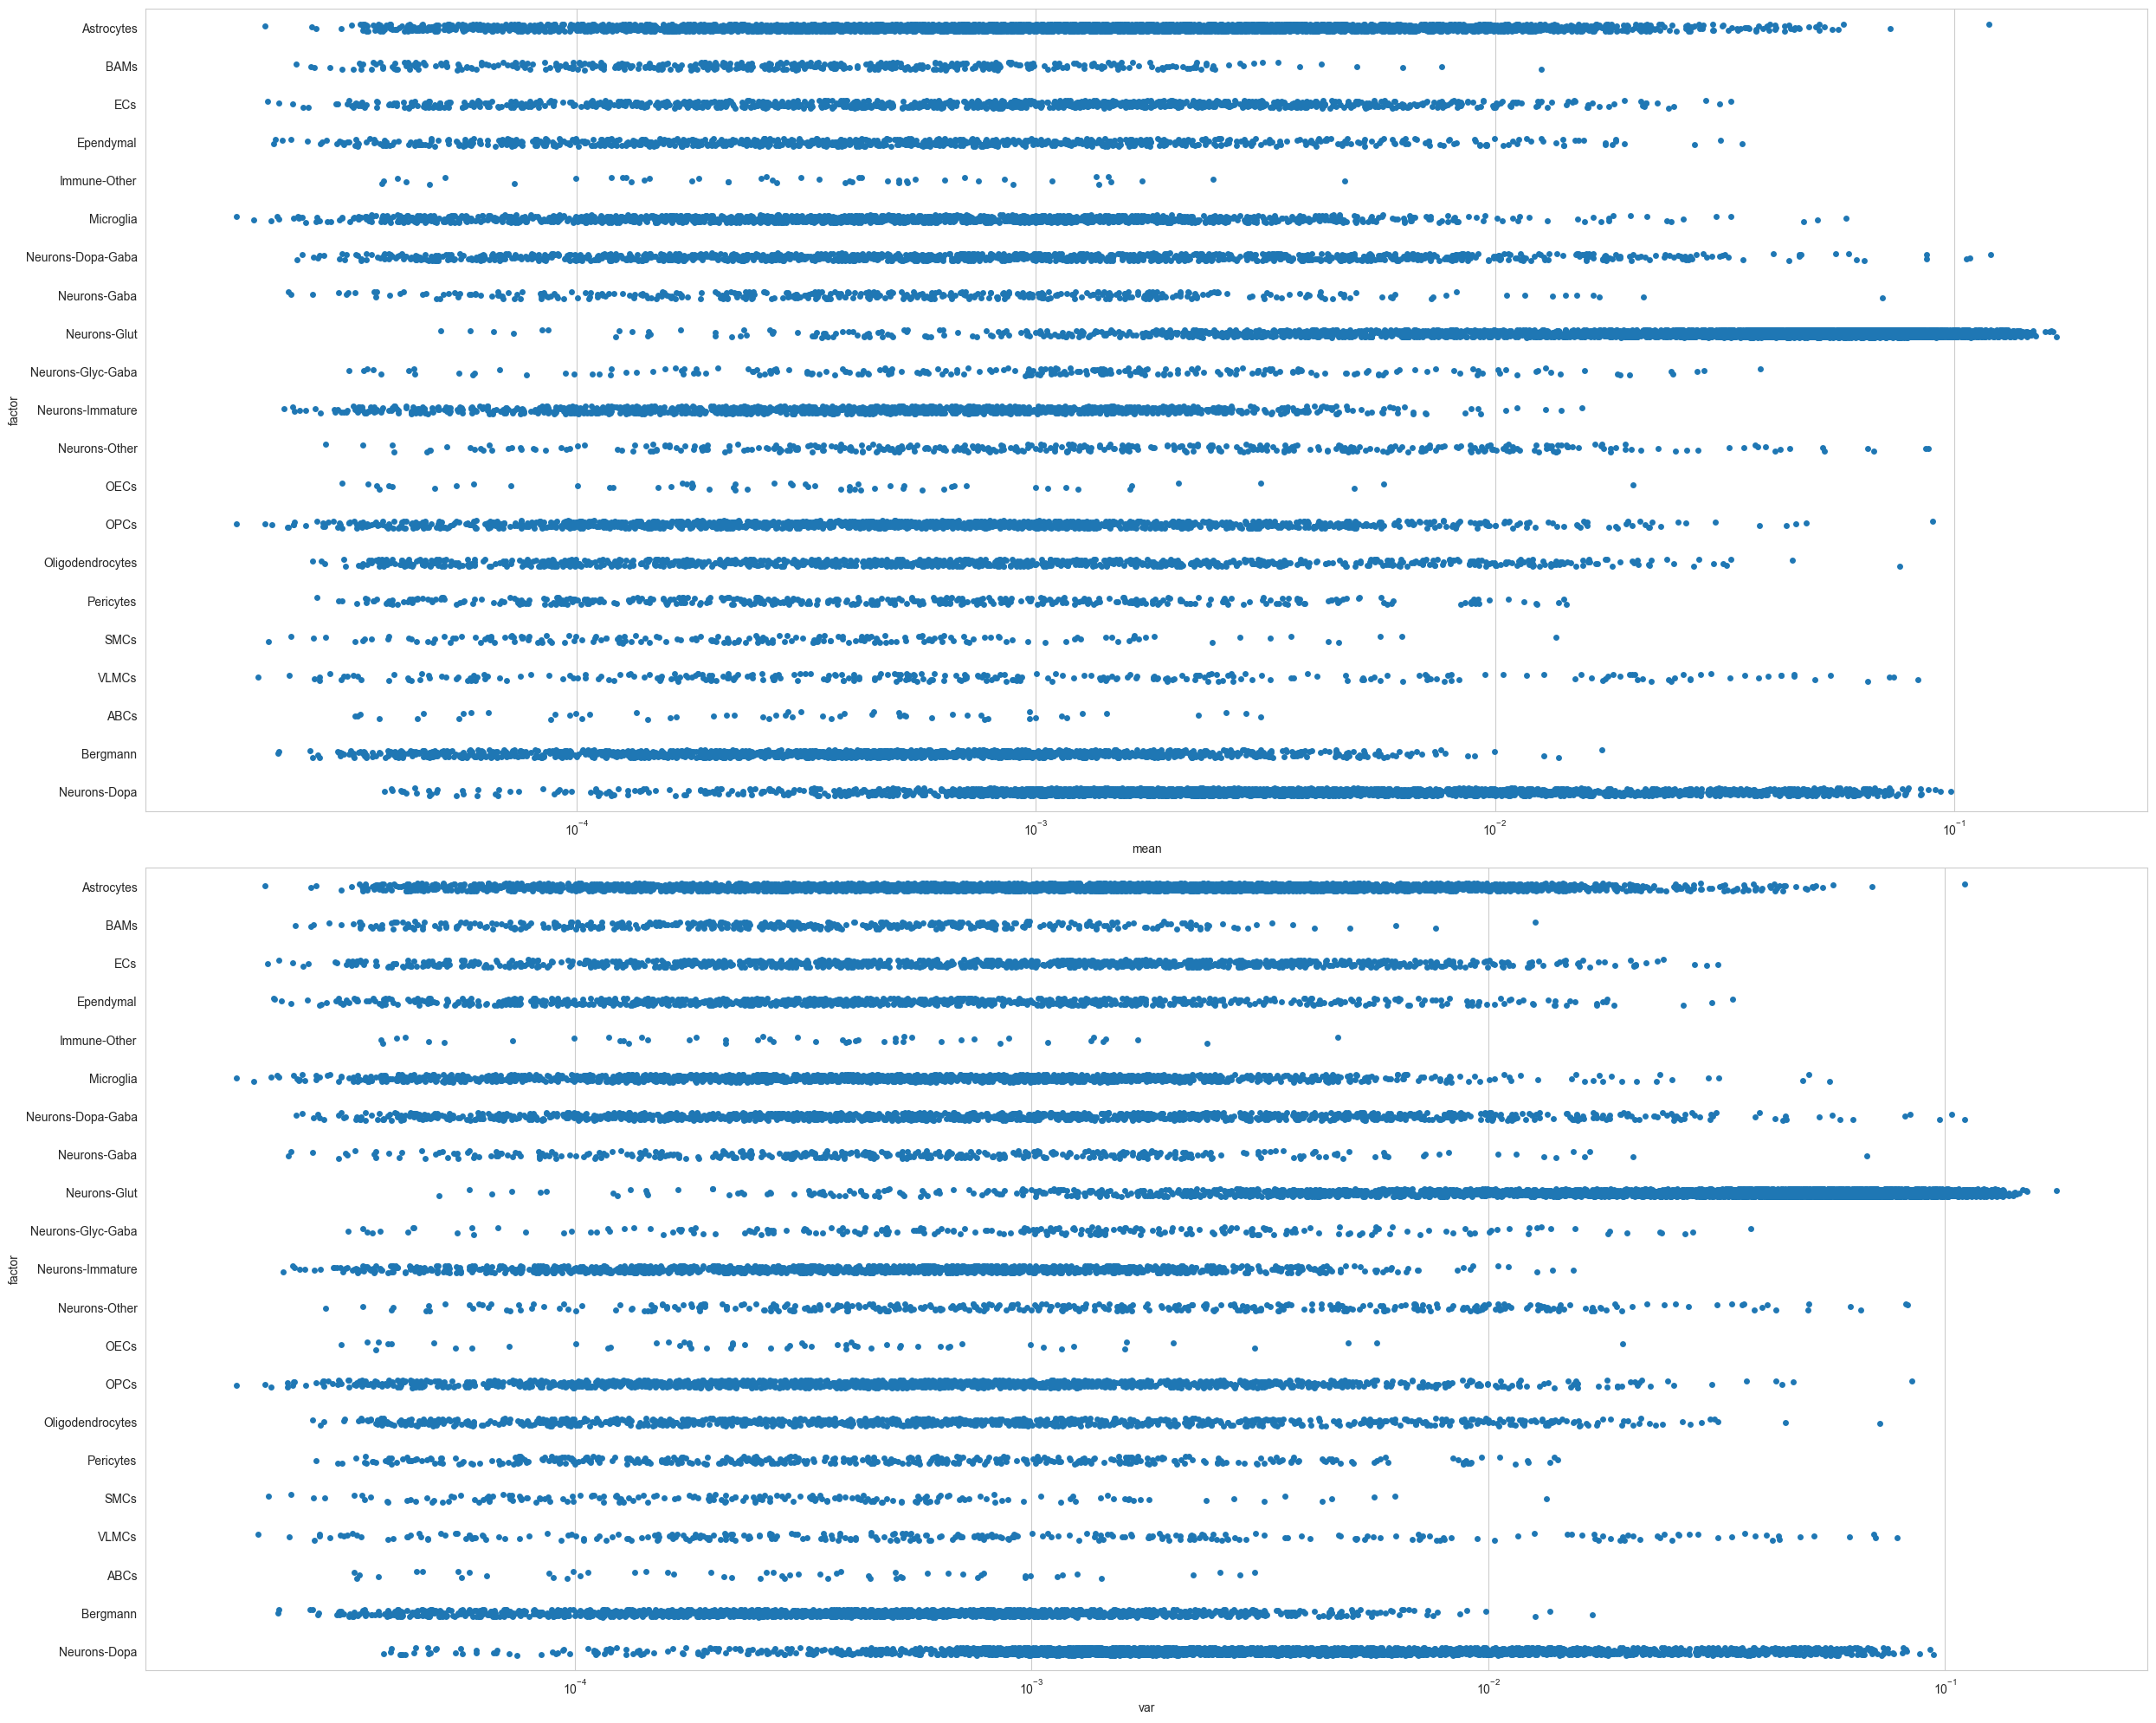

In [14]:
fig, axes = plt.subplots(2, 1, figsize=(25, 20))
sns.stripplot(
    pd.melt(
        means[
            (
                annotation.merge(means, left_index=True, right_index=True, how="right")[
                    "cell type"
                ]
                == "Neurons-Glut"
            ).values
        ],
        var_name="factor",
        value_name="mean",
    ),
    y="factor",
    x="mean",
    ax=axes[0],
    log_scale=True,
)
sns.stripplot(
    pd.melt(
        vars[
            (
                annotation.merge(vars, left_index=True, right_index=True, how="right")[
                    "cell type"
                ]
                == "Neurons-Glut"
            ).values
        ],
        var_name="factor",
        value_name="var",
    ),
    y="factor",
    x="var",
    ax=axes[1],
    log_scale=True,
)
plt.tight_layout()

In [ ]:
sns.stripplot(
    pd.melt(
        means_weight[
            (
                annotation.merge(
                    means_weight, left_index=True, right_index=True, how="right"
                )["cell type"]
                == "ECs"
            ).values
        ],
        var_name="factor",
        value_name="mean",
    ),
    y="factor",
    x="mean",
    hue="",
    log_scale=True,
)

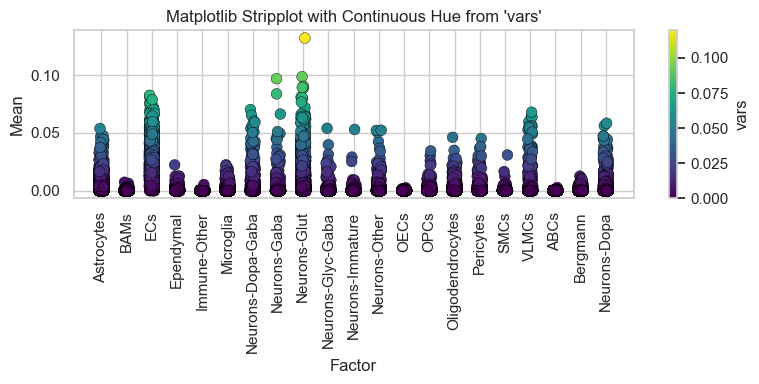

In [42]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Example data
mean_melt = pd.melt(
    means[
        (
            annotation.merge(means, left_index=True, right_index=True, how="right")[
                "cell type"
            ]
            == "ECs"
        ).values
    ],
    var_name="factor",
    value_name="mean",
    ignore_index=False,
)
mean_melt["cell_id"] = mean_melt.index
var_melt = pd.melt(
    vars[
        (
            annotation.merge(vars, left_index=True, right_index=True, how="right")[
                "cell type"
            ]
            == "ECs"
        ).values
    ],
    var_name="factor",
    value_name="vars",
    ignore_index=False,
)
var_melt["cell_id"] = var_melt.index
df = mean_melt.merge(
    var_melt, left_on=["cell_id", "factor"], right_on=["cell_id", "factor"], how="left"
)

# Get unique x positions for categorical "factor"
factors = df["factor"].unique()
factor_to_x = {factor: i for i, factor in enumerate(factors)}

# Normalize the 'vars' column for colormap
norm = mcolors.Normalize(vmin=df["vars"].min(), vmax=df["vars"].max())
cmap = cm.viridis

# Create the plot
plt.figure(figsize=(8, 4))
ax = plt.gca()

# Plot each point with jitter and color
for factor in factors:
    subset = df[df["factor"] == factor]
    x_vals = factor_to_x[factor] + np.random.uniform(
        -0.1, 0.1, size=len(subset)
    )  # jitter
    y_vals = subset["mean"]
    colors = cmap(norm(subset["vars"]))

    ax.scatter(x_vals, y_vals, c=colors, edgecolor="black", linewidth=0.3, s=60)

# Label x-axis with factor names
ax.set_xticks(list(factor_to_x.values()))
ax.set_xticklabels(factors)
ax.set_xlabel("Factor")
ax.set_ylabel("Mean")
ax.set_title("Matplotlib Stripplot with Continuous Hue from 'vars'")

# Add colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label="vars")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

<Axes: >

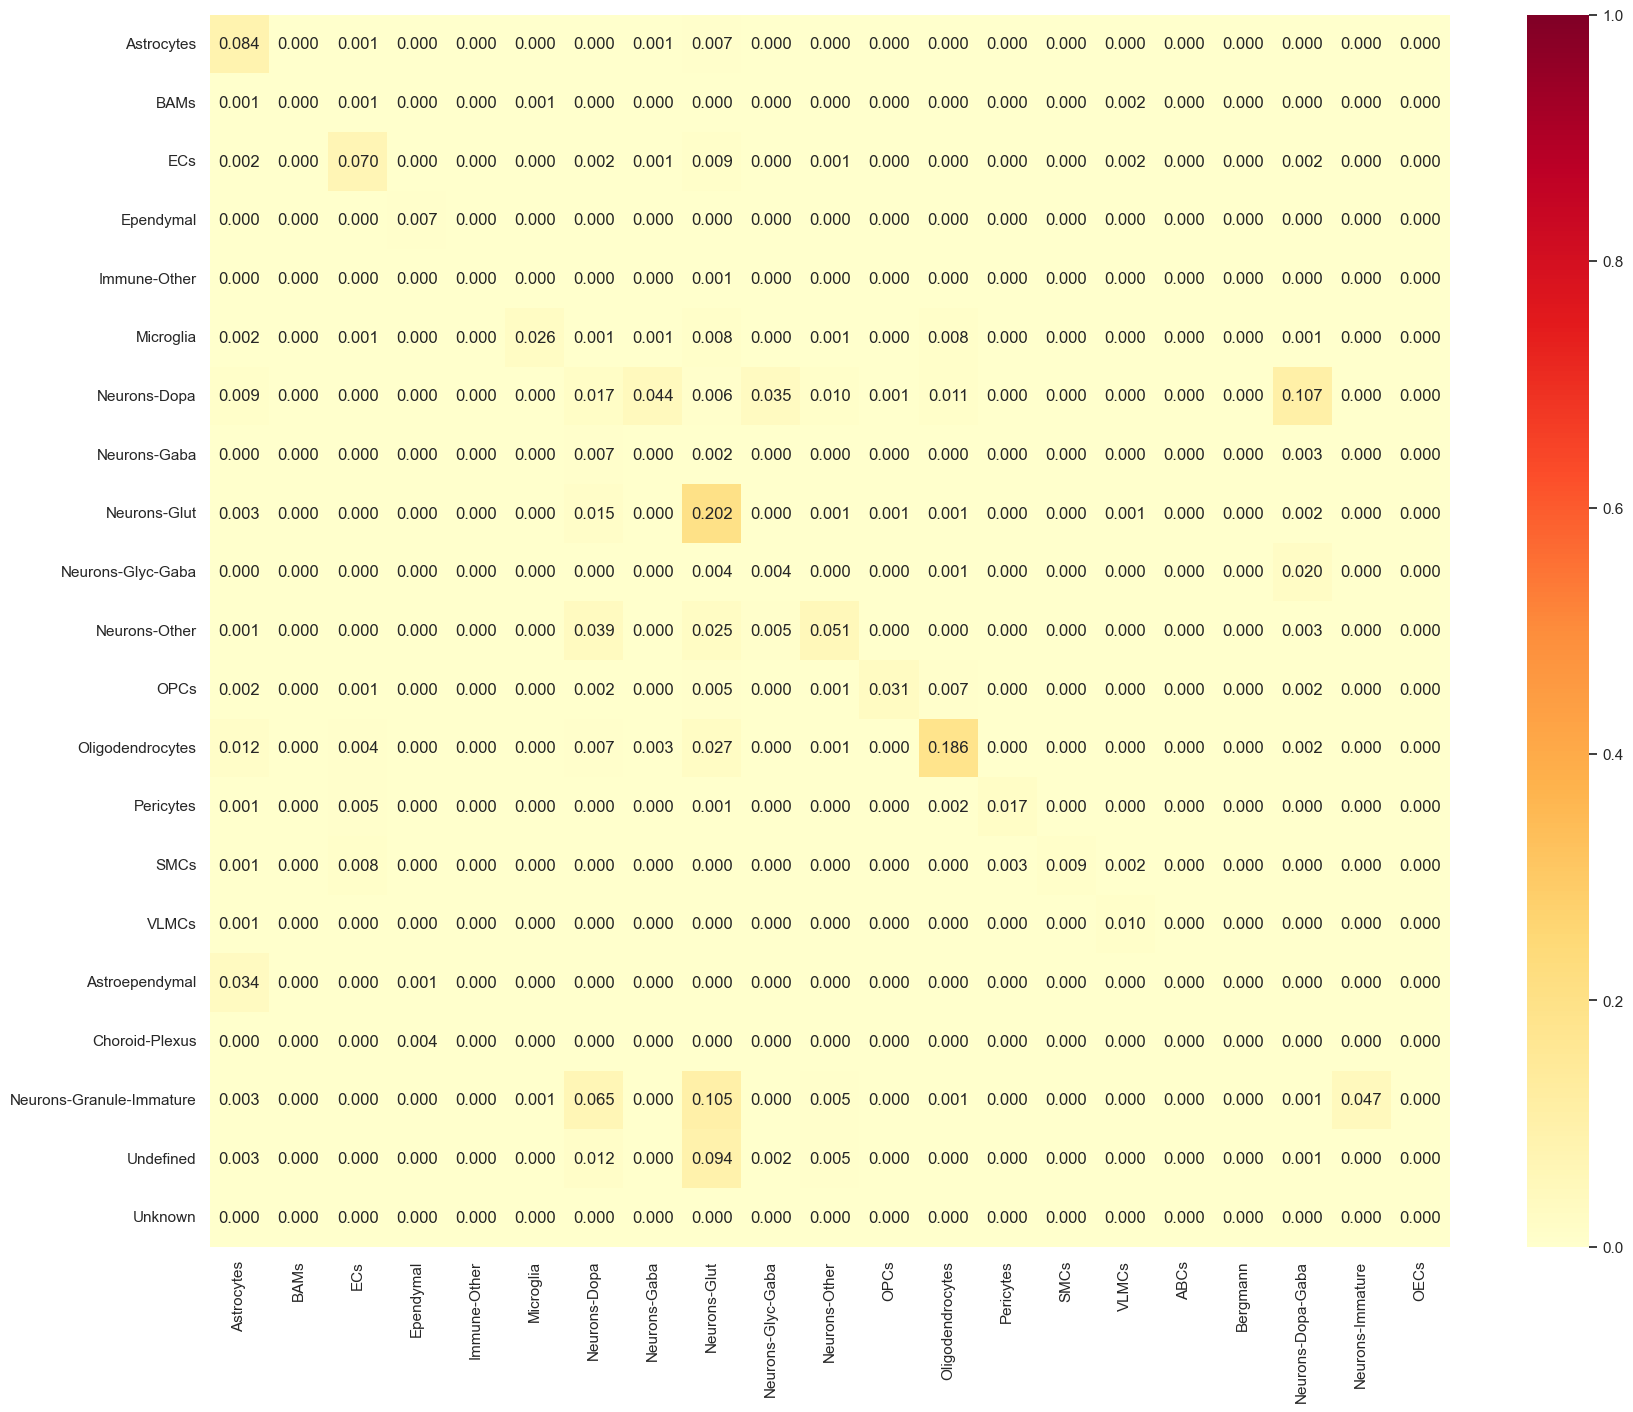

In [8]:
data = f1_adapted(means, 0.02).astype(float)
data.index = pd.CategoricalIndex(data.index, categories=index_order)
data.sort_index(level=0, inplace=True)
data = data[column_order]

sns.set_theme(rc={"figure.figsize": (20, 16)})
sns.heatmap(data, fmt=".3f", cmap="YlOrRd", vmin=0, vmax=1, annot=True)

In [10]:
min_values = []
for factor, cor_ct in true_cluster.items():
    min_values.append(
        means.loc[[x in cor_ct for x in means["cell type"]], factor].quantile(0.05)
    )
min_values = pd.DataFrame(
    np.array(min_values), index=true_cluster.keys(), columns=["0.25% quantile"]
)
min_values

,0.25% quantile
Astrocytes,0.000000
BAMs,0.000000
ECs,0.004883
Ependymal,0.000000
Immune-Other,0.000000
Microglia,0.000419
Neurons-Dopa-Gaba,0.000000
Neurons-Gaba,0.000000
Neurons-Glut,0.001978
Neurons-Glyc-Gaba,0.000000


<Axes: >

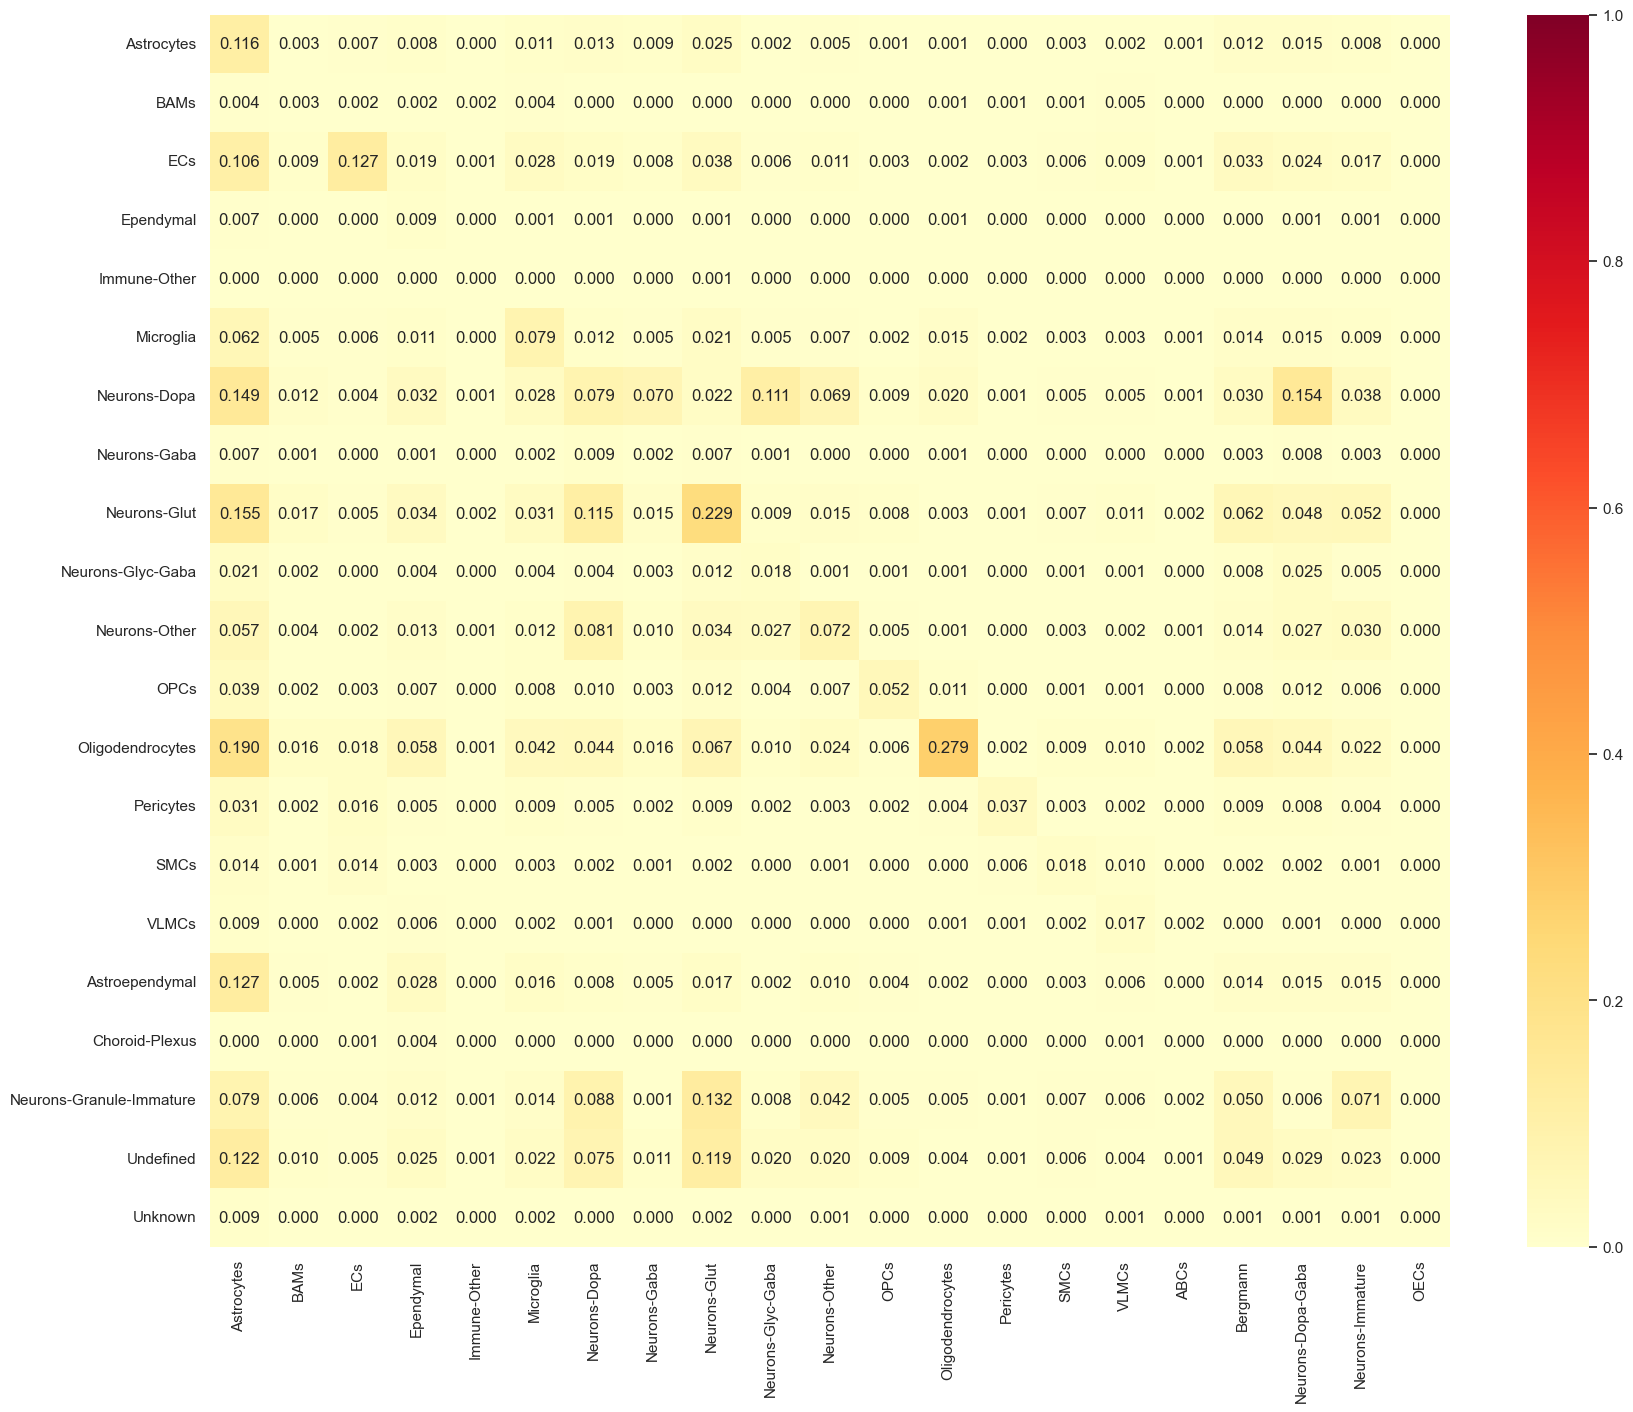

In [11]:
data = f1_adapted(means, min_values).astype(float)
data.index = pd.CategoricalIndex(data.index, categories=index_order)
data.sort_index(level=0, inplace=True)
data = data[column_order]

sns.set_theme(rc={"figure.figsize": (20, 16)})
sns.heatmap(data, fmt=".3f", cmap="YlOrRd", vmin=0, vmax=1, annot=True)

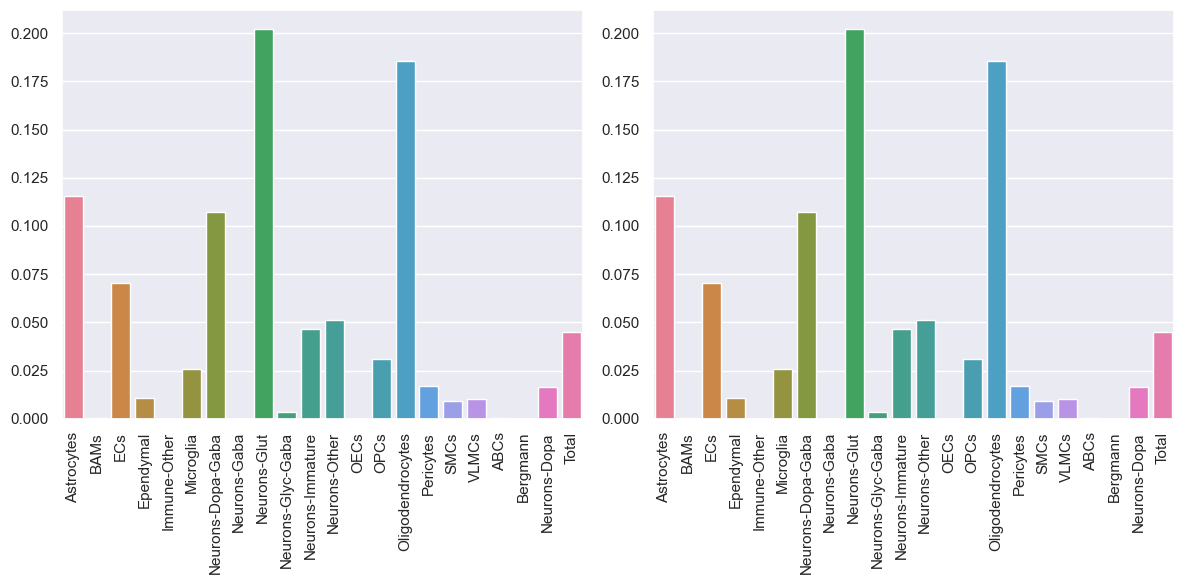

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.barplot(data=f1_adapted(means, 0.02, correct_celltypes), ax=axes[0])
axes[0].tick_params(axis="x", rotation=90)

sns.barplot(data=f1_adapted(means, 0.02, correct_celltypes), ax=axes[1])
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

<Axes: ylabel='Count'>

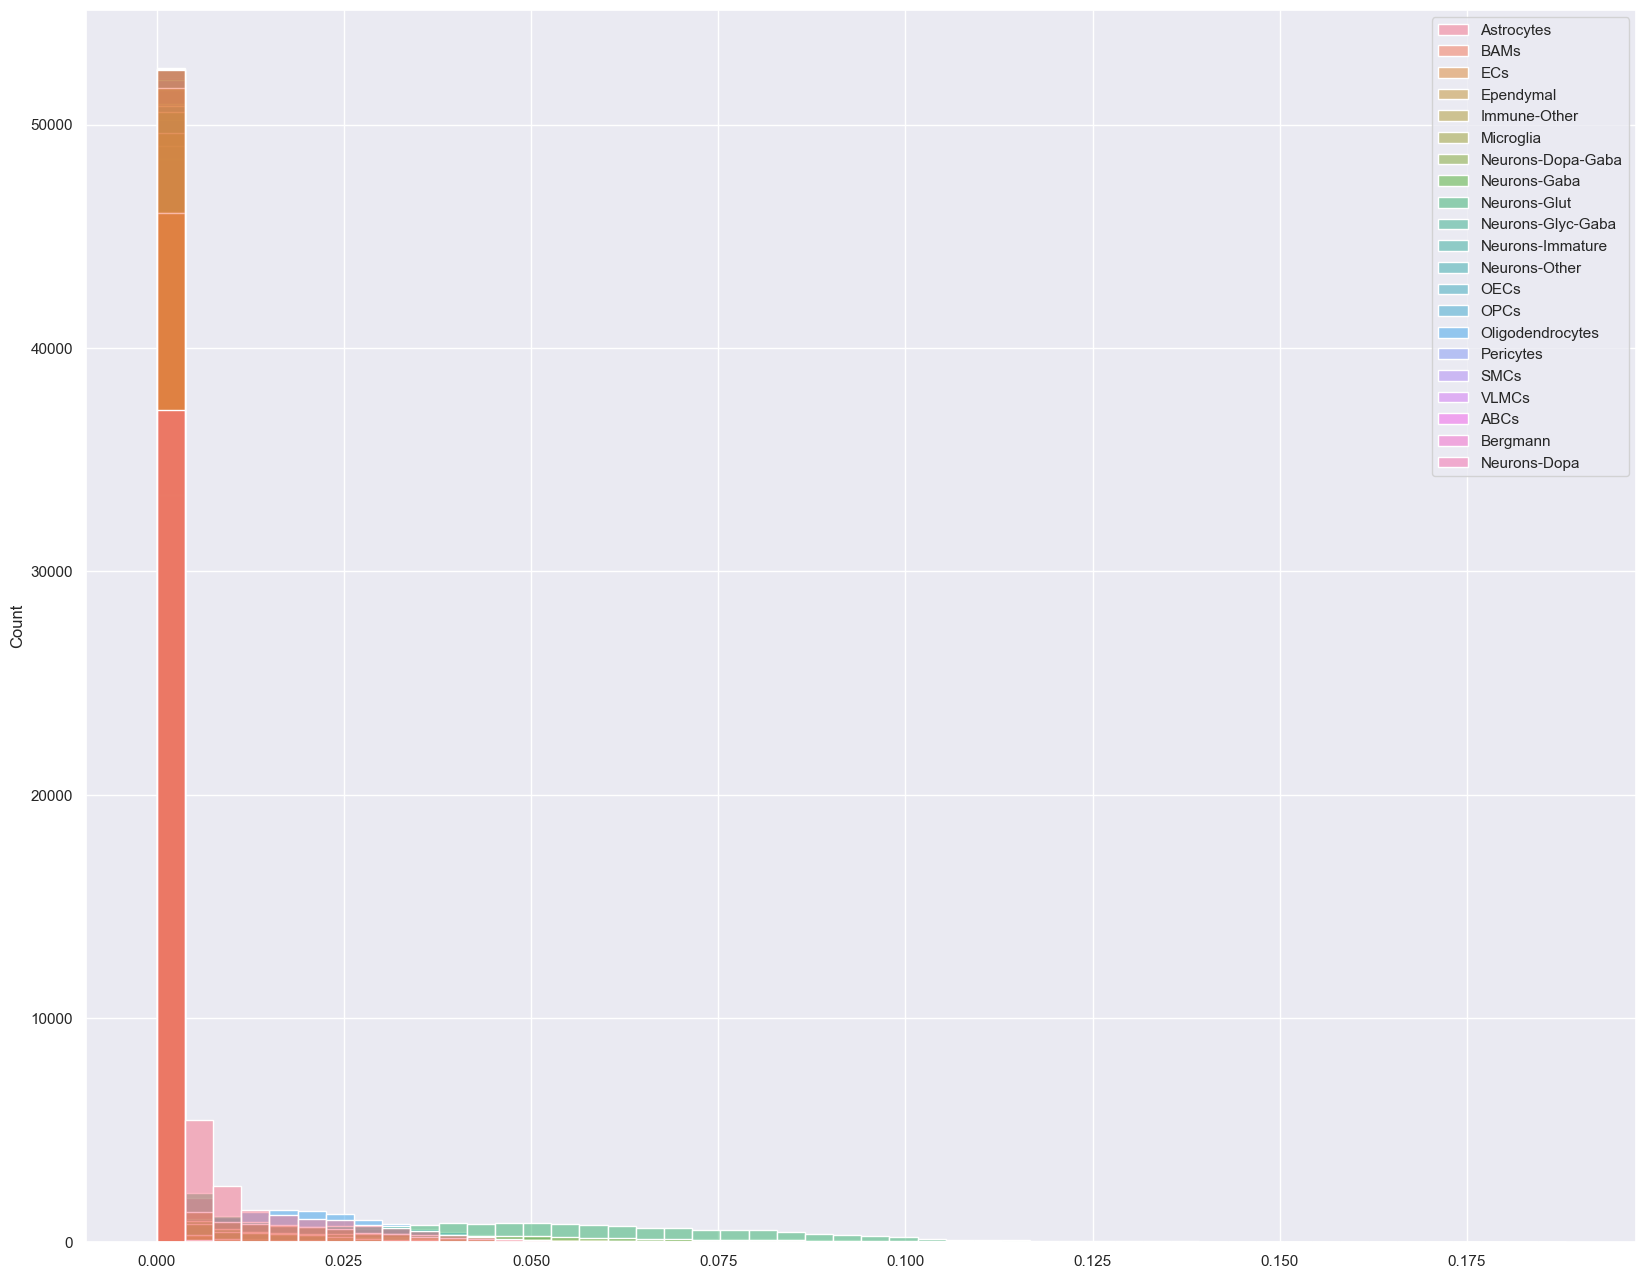

In [27]:
sns.histplot(means, bins=50)